In [8]:
# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import re, glob
import os, sys
from scipy import stats

import spotipy                          # Set up a config file with ckey and skey. These are available if you go
from spotipy.oauth2 import SpotifyClientCredentials      # to https://developer.spotify.com/, click on Dashboard 
                                        # from the horizontal black menu, login with your normal user info. Click 
# Import Keys                           # on "create an app" if you haven't yet, it doesn't matter what you call it.
from config import ckey, skey            # Then click into
                                        # your project and you should see Client ID and Client Secret. Those are your 
                                        # ckey and skey. 

In [9]:
# Setting up Spotify API info

# Setting up Spotify API info

client_credentials_manager = SpotifyClientCredentials(client_id=ckey, client_secret=skey)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


##TIP: This next section assumes that you have already downloaded the csv files with the Top200 charts for the country you are working on:

1. Create a subfolder in the folder this notebook is located in called "input_files". Add the owid-covid-data.csv file there, you'll need that later. Then make another subfolder inside input_files called "spotify_top200_charts". Save the csv files you download there. 
2. Go to https://spotifycharts.com
2. Choose the country you want to work on. 
3. Download Weekly Top200 charts for 2019 and 2020, 1 chart per month. We agreed as a group to download the chart from last week of each month, to keep things consistent. Save them in the "spotify_top200_charts" folder you set up. 

In [10]:
# Create dataframe from weekly chart data


path = r"input_files/spotify_top200_charts/*.csv"                # The path requires "".csv" at end of file name. 
                                                                 # This is to prevent the program from blowing up
                                                                 # when it hits some kind of hidden file. 

country_tracks_df = pd.read_csv(glob.glob(path)[0], header=1)    # Sets up **main dataframe** with data from **FIRST** file
string = str(glob.glob(path)[0])                                 # in the folder.
year_month, = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)   # This line extracts the year and month from the 
                                                                 # **file name**
country_tracks_df[['Year']] = year_month[0]
country_tracks_df[['Month']] = year_month[1]
country_tracks_df[['yyyy-mm']] = str(year_month[0]) + "-" + str(year_month[1]) 
Tot_Streams1 = country_tracks_df['Streams'].sum()                # Find out total streams in FIRST file in folder.
country_tracks_df[['Stream %']] = country_tracks_df['Streams'] / Tot_Streams1    # New column with % of streams

for file in glob.glob(path)[1:]:                                 # Now that you have the dataframe set up from the 
        temp_df = pd.read_csv(file, header=1)                    # first file in the folder, this iterates through 
        string = str(file)                                       # remaining files
        year_month, = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)
        #print (year_month)
        Tot_Streams2 = temp_df['Streams'].sum()
        temp_df[['Year']] = year_month[0]
        temp_df[['Month']] = year_month[1]
        temp_df[['yyyy-mm']] = str(year_month[0]) + "-" + str(year_month[1])
        temp_df[['Stream %']] = temp_df['Streams'] / Tot_Streams2
        country_tracks_df = pd.concat([country_tracks_df,        # Adds temperary datafame to end of main dataframe
                                       temp_df])                 # as new rows.  ¿¿¿???? 
        

                                                 
country_tracks_df = country_tracks_df.sort_values(['Year','Month'])  # Sort the new dataframe by year and month




                                                                 # You should get 4,800 rows (24 months x 200 
                                                                 # tracks per month)
country_tracks_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %
0,1,7 rings,Ariana Grande,71486,https://open.spotify.com/track/6ocbgoVGwYJhOv1...,2019,02,2019-02,0.022323
1,2,Shallow,Lady Gaga,67267,https://open.spotify.com/track/2VxeLyX666F8uXC...,2019,02,2019-02,0.021005
2,3,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,65006,https://open.spotify.com/track/7dbka99KTWke5o9...,2019,02,2019-02,0.020299
3,4,"break up with your girlfriend, i'm bored",Ariana Grande,62512,https://open.spotify.com/track/4kV4N9D1iKVxx1K...,2019,02,2019-02,0.019520
4,5,Con Calma,Daddy Yankee,59178,https://open.spotify.com/track/5w9c2J52mkdntKO...,2019,02,2019-02,0.018479
...,...,...,...,...,...,...,...,...,...
195,196,"Tujhe Kitna Chahein Aur (Film Version) [From ""...",Jubin Nautiyal,272866,https://open.spotify.com/track/3lT4SlZVvqLhMei...,2020,12,2020-12,0.002960
196,197,Mera Bhai,DIVINE,272385,https://open.spotify.com/track/3v3FEONiwvufayP...,2020,12,2020-12,0.002954
197,198,Fallin for You,Shrey Singhal,272266,https://open.spotify.com/track/3uOh60vBloFwAv1...,2020,12,2020-12,0.002953
198,199,"Hey Idi Nenena (From ""Solo Brathuke So Better"")",Thaman S,271156,https://open.spotify.com/track/4GC2IwmYrlC12Yf...,2020,12,2020-12,0.002941


In [11]:
# Get Track IDs
track_names = country_tracks_df['Track Name'].to_list()           # Set up list of tracks to iterate through         
track_ids = []                                                    # Empty list to record track IDs into

for track in track_names:                                         # Heads up: with 4800 tracks to process, this takes
    song_results = sp.search(q=track, type='track', limit=1)      # awhile 
    try:
        track_ids.append(song_results['tracks']['items'][0]['id']) # Prevents program from blowing up - few tracks
        print (f"{track} song ID : {song_results['tracks']['items'][0]['id']}")   # Just to let you know it's working
    except IndexError:                                             # lack track ids
        track_ids.append(np.nan)     

7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
break up with your girlfriend, i'm bored song ID : 4kV4N9D1iKVxx1KLvtTpjS
Con Calma song ID : 5w9c2J52mkdntKOmRLeM2m
Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
Talk song ID : 161DnLWsx1i3u1JT05lzqU
Duniyaa (From "Luka Chuppi") song ID : 2tjWCe2W7sgvS3C8NHcdtI
i'm so tired... song ID : 4vjpLMyL3ZO6aphdYr8XYw
Don't Call Me Up song ID : 5WHTFyqSii0lmT9R21abT8
Dancing With A Stranger (with Normani) song ID : 6Qs4SXO9dwPj5GKvVOv8Ki
Without Me song ID : 7lQ8MOhq6IN2w8EYcFNSUk
bury a friend song ID : 4SSnFejRGlZikf02HLewEF
Apna Time Aayega song ID : 5uaIbU3oHHcSOK6WFNK5nj
BIBA song ID : 1gt8YXWknKt4sRNZ6SirVW
No Sleep (feat. Bonn) song ID : 1ahVFh0ViDZr8LvkEVlq3B
Happier song ID : 2dpaYNEQHiRxtZbfNsse99
Who Do You Love song ID : 2fVHrSxsQbJUuj9MW9zG1e
Aankh Marey song ID : 63MvWd6T6yoS7h4AJ4Hjrm
She Move It Like song ID : 39vrbjCMTRXEdiIr2

O Saathi song ID : 6fScgF2Y63ScU73nYju0ny
Leja Re song ID : 68iBMrMRc1rg4eAxJbvxch
Always Remember Us This Way song ID : 2rbDhOo9Fh61Bbu23T2qCk
High Rated Gabru (From "Nawabzaade") song ID : 1ozrNv9W4KlprAmvgH0Yrq
Wildest Dreams song ID : 59HjlYCeBsxdI0fcm3zglw
SAD! song ID : 3ee8Jmje8o58CHK66QrVC2
There's No Way (feat. Julia Michaels) song ID : 0WTN7om3lHG3yYMigwzBxl
All Falls Down (feat. Juliander) song ID : 5yFSF6qQA1rcLsQRnBsZgb
Be Alright song ID : 3EPXxR3ImUwfayaurPi3cm
One Kiss (with Dua Lipa) song ID : 7ef4DlsgrMEH11cDZd32M6
Sanu Ek Pal Chain (From "Raid") song ID : 4wANB882g1ZhF2V8ugksY1
Dil Mein Ho Tum (From "Cheat India") song ID : 1mjWhM7GQTTxJxg2F0iCRS
Iktara song ID : 3jtKSUiVDowKNBqVQbWaig
Polaroid song ID : 49COPp81lGS9Hl9OwKlsKl
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Downtown song ID : 4kY7rYtE4OQkJNq22OIYRI
Aaya Na Tu song ID : 3T0oPETOdddxJ2xTt2qJe4
Sorry song ID : 7gvd8xj4QgPqbQSsn5pV7d
Let Me Go (with Alesso, Florida Georgia Line & watt) song ID : 5Gu0P

Lily song ID : 0lks2Kt9veMOFEAPN0fsqN
Khaab song ID : 0a6zRnrjmaOcqsEIFkXIhw
Bolna (From "Kapoor & Sons (Since 1921)") song ID : 3GrCQPpKqKzOcKfMAoqn82
Hope song ID : 2ZRo7axmMPeSVUvDbGkJah
lovely song ID : 0u2P5u6lvoDfwTYjAADbn4
Urvashi song ID : 342pJxy678kgQrZXCL9RG7
Youngblood song ID : 2iUXsYOEPhVqEBwsqP70rE
Doori song ID : 5doYtCoJ8KpfkFczP3F2ad
nan song ID : 0Psz3az3RIYfJpnsajBT8N
Lost Control song ID : 0lG6QM1jjbbX5UUn3DPmrZ
Othaiyadi Pathayila song ID : 09Z6o1yu596HJAwWZxTz4m
Saturday Nights song ID : 5kfNriitmkNE8mUbZ7gbq8
Ruin My Life song ID : 5tAa8Uaqr4VvA3693mbIhU
New Rules song ID : 2ekn2ttSfGqwhhate0LSR0
Pa Mí - Remix song ID : 7g8YaUQABMal0zWe7a2ijz
High Rated Gabru (From "Nawabzaade") song ID : 1ozrNv9W4KlprAmvgH0Yrq
Mere Gully Mein (feat. Naezy) song ID : 4NEdR5Yo8D2KwL7Y9KW7EH
Agar Tum Saath Ho (From "Tamasha") song ID : 2FCXQHugkoHE1K3tiDu8pu
Scared to Be Lonely song ID : 3ebXMykcMXOcLeJ9xZ17XH
Silence song ID : 7vGuf3Y35N4wmASOKLUVVU
Hasi - Female Version song ID 

Treat You Better song ID : 3QGsuHI8jO1Rx4JWLUh9jd
This Feeling song ID : 4NBTZtAt1F13VvlSKe6KTl
Dil Chori song ID : 6zojSFiUNySBy3Kd1JVCXb
Kamariya song ID : 5cjVsWqIkBQC7acTRhL0RO
Darkside song ID : 6SRWhUJcD2YKahCwHavz3X
Tera Yaar Hoon Main (From "Sonu Ke Titu Ki Sweety") song ID : 1aIhAX6324JZmhNnGltwkK
Dil Mein Ho Tum (From "Cheat India") song ID : 1mjWhM7GQTTxJxg2F0iCRS
Surma Kaala song ID : 0rJYDeeUkMpWDs2eKWoDtB
Something Just Like This song ID : 6RUKPb4LETWmmr3iAEQktW
Iktara song ID : 3jtKSUiVDowKNBqVQbWaig
Lily song ID : 0lks2Kt9veMOFEAPN0fsqN
Rowdy Baby song ID : 0Tm5ER6IrGfmW0yZ5lkQli
Thunder song ID : 1zB4vmk8tFRmM9UULNzbLB
Suit Suit song ID : 2mwBSO58y92EYmEFpDfmS7
Dusk Till Dawn - Radio Edit song ID : 1j4kHkkpqZRBwE0A4CN4Yv
Back To You - From 13 Reasons Why – Season 2 Soundtrack song ID : 4hQ6UGyWQIGJmHSo0J88JW
Teri Mitti - Female Version (Kesari) song ID : 6bY2lEYwgJRnoPWWT1Hld9
No Sleep (feat. Bonn) song ID : 1ahVFh0ViDZr8LvkEVlq3B
Photograph song ID : 1HNkqx9Ahdgi1Ixy2

Morni Banke (From "Badhaai Ho") song ID : 2Wu9PNpLUCBl3W1GaPqkhl
Kill This Love song ID : 6hvczQ05jc1yGlp9zhb95V
Sakhiyaan song ID : 3sqRODOZ1Z6hR4F2tnFAlg
Talk (feat. Disclosure) song ID : 6TqXcAFInzjp0bODyvrWEq
Rescue Me song ID : 0mjAU3yKR1QnXnHtjGJqTM
Slowly Slowly song ID : 4pBxb7WuLsC3YyA9cj4T2l
Akh Lad Jaave song ID : 554Jv8PaaIVAwOOpoJ4YCm
Who Do You Love song ID : 2fVHrSxsQbJUuj9MW9zG1e
Cradles song ID : 1y4jsQt7MjnZhiD1L6qFBC
Summer Days (feat. Macklemore & Patrick Stump of Fall Out Boy) song ID : 7Feaw9WAEREY0DUOSXJLOM
Tareefan song ID : 5QyOjKJhR1iyF0DHQM2IvW
Dekhte Dekhte (From "Batti Gul Meter Chalu") song ID : 0Iz4CkptElGHo16r797Jsb
Enna Sona song ID : 6bdpj89aYEBjhpsenXAsmO
Main Wahi Hoon song ID : 0DpRQilfVixvmhqoHJK8Hk
Tough Love song ID : 1yfyIdEw5U2bD5I6gxQCxW
Don't Call Me Up song ID : 5WHTFyqSii0lmT9R21abT8
Girls Like You (feat. Cardi B) song ID : 6V1bu6o1Yo5ZXnsCJU8Ovk
bury a friend song ID : 4SSnFejRGlZikf02HLewEF
Qaafirana song ID : 0xkGTPTijMU84dtHr3KQQi
Taki 

Kannamma - From "Ispade Rajavum Idhaya Raniyum" song ID : 4KUQFOGTaHrggl3hfMoaAe
Señorita song ID : 0TK2YIli7K1leLovkQiNik
Bekhayali (From "Kabir Singh") song ID : 1feANd8EfcDP5UqSvbheM3
Tujhe Kitna Chahne Lage (From "Kabir Singh") song ID : 2Fv2injs4qAm8mJBGaxVKU
Mere Sohneya (From "Kabir Singh") song ID : 2IoZMG3RqiTmsy7Li3zGFg
Kaise Hua (From "Kabir Singh") song ID : 1y1rQTkWmrZdJmjwuK07GC
Tera Ban Jaunga song ID : 3oWxFNsXstcancCR1wODR4
Bekhayali (Arijit Singh Version) [From "Kabir Singh"] song ID : 6aPMWbbdhDhiJHlknZb9Yx
Duniyaa (From "Luka Chuppi") song ID : 2tjWCe2W7sgvS3C8NHcdtI
You Need To Calm Down song ID : 6RRNNciQGZEXnqk8SQ9yv5
Ve Maahi song ID : 4t1DkxexoMbIHfSHS4Uiyr
bad guy song ID : 2Fxmhks0bxGSBdJ92vM42m
Old Town Road (feat. Billy Ray Cyrus) - Remix song ID : 6zpiwiexX8HpFCZLyIWKDv
Vaaste song ID : 0mJTAdmY8olbGQjopDYff3
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Call You Mine (feat. Bebe Rexha) song ID : 5EdYlCWou17k0N1PADLKfO
Tujh

Stitches song ID : 5jsw9uXEGuKyJzs0boZ1bT
The Middle song ID : 6GG73Jik4jUlQCkKg9JuGO
It Ain't Me (with Selena Gomez) song ID : 2jRGYG8U5bJzWOH6FLuzvO
Daryaa song ID : 6dN6k8fcjeB3Z2zLnxeyhP
Azadi song ID : 07qSl2sNpFNILaYyZ6yIS9
Say You Won't Let Go song ID : 5uCax9HTNlzGybIStD3vDh
Kar Gayi Chull song ID : 3fPgIknlkDWXs1l2noKZbp
Don't Call Me Up song ID : 5WHTFyqSii0lmT9R21abT8
Bolna (From "Kapoor & Sons (Since 1921)") song ID : 3GrCQPpKqKzOcKfMAoqn82
Sajna Ve song ID : 1lWjvbQWru7XPekvQGiKv5
Close To Me (with Diplo) (feat. Swae Lee) song ID : 5JEx7HbmvHQQswJCsoo9rA
Choo Lo song ID : 2qgXrzJsry4KgYoJCpuaul
Psycho (feat. Ty Dolla $ign) song ID : 3swc6WTsr7rl9DqQKQA55C
Jeena Jeena (From "Badlapur") song ID : 5ZhKD46Q7mhsl0awl7ZMJc
Zindagi Di Paudi (From "Blessed") song ID : 5HZ7sLkQU5PRYZEkQKG145
High Rated Gabru (From "Nawabzaade") song ID : 1ozrNv9W4KlprAmvgH0Yrq
Illegal Weapon song ID : 5fXslGZPI5Cco6PKHzlSL3
Sher Aaya Sher song ID : 2qPNdVlqZl1cYqsNc3MXnA
Ik Vaari Aa (From "Raabta")

Kaash Aisa Hota song ID : 32IjXlRFxNtJ4eMhKAUrSX
Money In The Grave (Drake ft. Rick Ross) song ID : 5ry2OE6R2zPQFDO85XkgRb
I Like Me Better song ID : 2P91MQbaiQOfbiz9VqhqKQ
Saara India song ID : 46GBoFCdFZZSjuGaZjZmGv
Teri Mitti song ID : 3PAC15iDIHk7IWD8ShSgWh
Naina Da Kya Kasoor song ID : 4JQxGJ8jsKW8pOUVoAgOZr
High Rated Gabru (From "Nawabzaade") song ID : 1ozrNv9W4KlprAmvgH0Yrq
Treat You Better song ID : 3QGsuHI8jO1Rx4JWLUh9jd
Girls Like You (feat. Cardi B) song ID : 6V1bu6o1Yo5ZXnsCJU8Ovk
Taki Taki (with Selena Gomez, Ozuna & Cardi B) song ID : 4w8niZpiMy6qz1mntFA5uM
Old Town Road - Remix song ID : 2YpeDb67231RjR0MgVLzsG
Kabira song ID : 4bD9z9qa4qg9BhryvYWB7c
Tommy song ID : 5QZKcQDp0tCcvMdyqEciBV
Kar Gayi Chull song ID : 3fPgIknlkDWXs1l2noKZbp
Let Me Love You song ID : 3ibKnFDaa3GhpPGlOUj7ff
Urvashi song ID : 342pJxy678kgQrZXCL9RG7
Tera Shehar (feat. Mohd. Kalam) song ID : 1g4ROF1TLFOxIckKlh5bp5
Viah song ID : 12V0iduYsoXxsQYTSeFB2H
Jugraafiya song ID : 5BgtNz0AsCIIu2pfbCfq5c
Me

First Class song ID : 7trx783SvnHhKkmgSSTIFJ
Photo (From "Luka Chuppi") song ID : 5wdlz4N7s1Xyr4y4RXhZJM
Aankh Marey (From "Simmba") song ID : 63MvWd6T6yoS7h4AJ4Hjrm
Pal song ID : 4UiaP0wBuy9N9voD91OZOg
Loco Contigo (feat. J. Balvin & Tyga) song ID : 6osaMSJh9NguagEDQcZaKx
Teri Mitti song ID : 3PAC15iDIHk7IWD8ShSgWh
Main Deewana Tera (From "Arjun Patiala") song ID : 5n8BCU2JmPORrFboGeDlXV
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Without Me song ID : 7lQ8MOhq6IN2w8EYcFNSUk
Believer song ID : 0pqnGHJpmpxLKifKRmU6WP
Rula Diya (From "Batla House") song ID : 6sTbnkzOtPpojgnn50cCHJ
Miss Americana & The Heartbreak Prince song ID : 214nt20w5wOxJnY462klLw
Slow Motion (From "Bharat") song ID : 7yEuRloGyxyu1KaWBTPP1Z
Baby Won't You Tell Me (From "Saaho") song ID : 5JOsGkhl49EoiBQpZLL1SC
Dil Mein Ho Tum (From "Cheat India") song ID : 1mjWhM7GQTTxJxg2F0iCRS
Chogada (From "Loveyatri") song ID : 4ymPEyiXabTe1NO8q8EFxG
Qaafirana song ID : 0xkGTPTijMU84dtHr3KQQi
Kaam 25 - Sacred Games song ID

Duniyaa (From "Luka Chuppi") song ID : 2tjWCe2W7sgvS3C8NHcdtI
Kaise Hua (From "Kabir Singh") song ID : 1y1rQTkWmrZdJmjwuK07GC
Circles song ID : 21jGcNKet2qwijlDFuPiPb
Memories song ID : 2b8fOow8UzyDFAE27YhOZM
Bad Boy (From "Saaho") song ID : 5I3Xih0C2ID3fqngBrBbGv
Goodbyes (Feat. Young Thug) song ID : 0t3ZvGKlmYmVsDzBJAXK8C
Liar song ID : 7LzouaWGFCy4tkXDOOnEyM
Ik Mulaqaat song ID : 17uI7afUaul1hCzMTF9txd
Sakhiyaan song ID : 3sqRODOZ1Z6hR4F2tnFAlg
changes song ID : 7AFASza1mXqntmGtbxXprO
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Kalank (Title Track) song ID : 6vo7Y1iWyZvpjvFbf6BiZ5
Bekhayali (Arijit Singh Version) [From "Kabir Singh"] song ID : 6aPMWbbdhDhiJHlknZb9Yx
Kohinoor song ID : 1VYMsDdZ3toHtlZxAGS95n
Vaaste song ID : 0mJTAdmY8olbGQjopDYff3
Chale Aana (From "De De Pyaar De") song ID : 6vuMdb0E8buJeSHArN3dXk
The Wakhra Song song ID : 6N6mJlsjYRV0yoMSPS5JiQ
Prada song ID : 1N0wLru7OxcfPsAa6bYfOr
Paagal song ID : 4gyPGtExOjj1rsByKW33LR
I Like Me

Akh Lad Jaave song ID : 554Jv8PaaIVAwOOpoJ4YCm
Wolves song ID : 33gwZOGJWEZ7dRWPqPxBEZ
Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
Boy With Luv (feat. Halsey) song ID : 5KawlOMHjWeUjQtnuRs22c
lovely (with Khalid) song ID : 0u2P5u6lvoDfwTYjAADbn4
Tera Zikr song ID : 0OfaueVeRebAfWsAHajj3z
Romantic Mashup 2 song ID : 42WGQxg2lPIFBt8ZRHQ4Q4
Kabira song ID : 4bD9z9qa4qg9BhryvYWB7c
Koi Nahi song ID : 1OA2kU6GzHvj9efjqJ1XD1
Ishq Tera song ID : 1aUfggX5E0nKDikNuiDQ3D
tere bina song ID : 4FeczSomVWVyU4FW7xDeAI
Kyun Rabba song ID : 68QwG6Ni1jFQc5Fit2iXp0
Sachiya Mohabbatan (From "Arjun Patiala") song ID : 28w9HJdplcvHhwwRIbcoKY
Gali Gali (From "Kgf Chapter 1") song ID : 5x72Q1SyiDHJ4IF2mRzfkg
Sau Aasmaan song ID : 0zHZSO80CTxNtvtRhveHRJ
Satisfya song ID : 6HGoVbCUr63SgU3TjxEVj6
Jind Mahi song ID : 3SJVCbBFTxR6UvvTWRNbMp
I Don’t Wanna Live Forever (Fifty Shades Darker) song ID : 55n9yjI6qqXh5F2mYvUc2y
Sye Raa (From "Sye Raa Narasimha Reddy") song ID : 7uCqKbtBfGaURLUC0W9UAX
Bulleya song ID : 0Bz7dfqPY

Hawayein song ID : 0l6g8Z8mqGbGXFOjigYetD
The Humma Song song ID : 7heMX7gyHP0mhTlNgd7Lxd
Radhe Radhe song ID : 1HbmeBqRlEk54KK8gxQqbZ
Verithanam (From "Bigil") song ID : 6YhDs8isyaiVECBSViAFDS
Treat You Better song ID : 3QGsuHI8jO1Rx4JWLUh9jd
Yeh Aaina song ID : 62RXe5I6L7n32fUMd8Puvo
Panini song ID : 1000nHvUdawXuUHgBod4Wv
Hawa Banke song ID : 1L3Nsi7YXtBxTdnbqektia
Viah song ID : 12V0iduYsoXxsQYTSeFB2H
rockstar (feat. 21 Savage) song ID : 0e7ipj03S05BNilyu5bRzt
Crazy Habibi Vs Decent Munda (From "Arjun Patiala") song ID : 7yy3HgKJEcwArL5k0v5rhF
Sorry Song song ID : 6RnFfNQik3Cq6vrmifPMlA
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
So Gaya Yeh Jahan song ID : 6HlKDKcgvwjvWPrYIqMSaK
Let Me Love You song ID : 3ibKnFDaa3GhpPGlOUj7ff
Call You Mine song ID : 2oejEp50ZzPuQTQ6v54Evp
Cradles song ID : 1y4jsQt7MjnZhiD1L6qFBC
Enna Sona song ID : 6bdpj89aYEBjhpsenXAsmO
Sawarne Lage song ID : 7E4sdzJDrVMu8qcwyxz3vP
Enni Soni (From "Saaho") song ID : 40S8Et5fYlBCa0QgBTEOE1
Khud Se Zyada song ID : 1v

Lehanga song ID : 5WIGGlMpT8F9JTkU2uJUgZ
Khairiyat song ID : 5O932cZmzOZGOGZz9RHx20
I Like Me Better song ID : 2P91MQbaiQOfbiz9VqhqKQ
Prada song ID : 1N0wLru7OxcfPsAa6bYfOr
Tera Yaar Hoon Main (From "Sonu Ke Titu Ki Sweety") song ID : 1aIhAX6324JZmhNnGltwkK
Coca Cola (From "Luka Chuppi") song ID : 352wEkChkiClswqwDoM0nj
Graveyard song ID : 2ufmtcIFdFpuUYBPXK5f67
The Wakhra Song song ID : 6N6mJlsjYRV0yoMSPS5JiQ
She Move It Like song ID : 39vrbjCMTRXEdiIr2IsBgd
Paagal song ID : 4gyPGtExOjj1rsByKW33LR
Dil Diyan Gallan song ID : 5MnAi6ZF7cE8pAz7wYr9Ta
The Jawaani Song song ID : 3IzQc4KEAFd8lIc90X7FZr
Dilbar (From "Satyameva Jayate") song ID : 4tjLYTXFqZhkUDga4bQ0yl
Dekhte Dekhte (From "Batti Gul Meter Chalu") song ID : 0Iz4CkptElGHo16r797Jsb
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
Qaafirana song ID : 0xkGTPTijMU84dtHr3KQQi
Apna Time Aayega song ID : 5uaIbU3oHHcSOK6WFNK5nj
Photo (From "Luka Chuppi") song ID : 5wdlz4N7s1Xyr4y4RXhZJM
Faded song ID : 7gHs73wELdeycvS48JfIos
Combination song ID

Jai Jai Shivshankar (From "War") song ID : 6lfSsCL894Qw15xbt7cSUy
Believer song ID : 0pqnGHJpmpxLKifKRmU6WP
hot girl bummer song ID : 2mt1IqcFyY1zmYZT8Q3xw9
My Oh My (feat. DaBaby) song ID : 3yOlyBJuViE2YSGn3nVE1K
everything i wanted song ID : 3ZCTVFBt2Brf31RLEnCkWJ
bad guy song ID : 2Fxmhks0bxGSBdJ92vM42m
Proper Patola song ID : 39ujbBjTwwqUFySaCYDMMT
Vaaste song ID : 0mJTAdmY8olbGQjopDYff3
Don't Be Shy Again (From "Bala") song ID : 2TbCdbFzs2xO2nzasn0Qvw
Ik Tera song ID : 57DhVYA7E1CyrE4OKuyLb7
Lucid Dreams song ID : 285pBltuF7vW8TeWk8hdRR
Kalank (Title Track) song ID : 6vo7Y1iWyZvpjvFbf6BiZ5
I Like Me Better song ID : 2P91MQbaiQOfbiz9VqhqKQ
Chandigarh Mein song ID : 3Eb4VbsbXMpS5Mk9HWTDia
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Dance Like song ID : 1rwSZ2WvPoGArYIByVSEGW
Lose You To Love Me song ID : 4l0Mvzj72xxOpRrp6h8nHi
Adore You song ID : 3jjujdWJ72nww5eGnfs2E7
Hauli Hauli (From "De De Pyaar De") song ID : 60XrRbNjDMAGUZ2xLkU9W3
Mummy Nu Pasand (From "Jai Mummy Di") s

Gal Karke song ID : 79XBui7ea1RGjlC57AH0w1
Up All Night song ID : 1mpD5Q8IM32I4bF6eCpU74
Blah Blah Blah song ID : 7lWUJpax919G4JdaFEVmCy
Sage song ID : 1UMKquW1olreYO1LlLmTqi
Romantic Mashup 2 song ID : 42WGQxg2lPIFBt8ZRHQ4Q4
I Can’t Get Enough (benny blanco, Selena Gomez, J Balvin, Tainy) song ID : 1WSGTYKLEpKfNQYYW5Oymt
O Saathi song ID : 6fScgF2Y63ScU73nYju0ny
Illegal Weapon 2.0 (From "Street Dancer 3D") song ID : 5fXslGZPI5Cco6PKHzlSL3
Muqabla (From "Street Dancer 3D") song ID : 28veUNu4veN0LOBVa0nFw8
Garmi (From "Street Dancer 3D") (feat. Varun Dhawan) song ID : 6q9XTgfWilsnyiFofvYrIF
Yummy song ID : 41L3O37CECZt3N7ziG2z7l
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
Makhna song ID : 0ZHILXmUaVSLEOCWxPQ1ga
Lagdi Lahore Di (From "Street Dancer 3D") song ID : 5I2wbDvSI98HLVB42YO9sU
Malang (Title Track) [From "Malang - Unleash The Madness"] song ID : 25MPTnqXQB1H6OkwSYUXWx
Ghungroo (From "War") song ID : 0WdbnNKO0Jt4BZACSDQh44
Black Swan song ID : 3bkkMZEAhx7rTVz1C0itRQ
Godzilla (feat. J

The Wakhra Song song ID : 6N6mJlsjYRV0yoMSPS5JiQ
Khaab song ID : 0a6zRnrjmaOcqsEIFkXIhw
Khairiyat song ID : 5O932cZmzOZGOGZz9RHx20
Girls Like You (feat. Cardi B) song ID : 6V1bu6o1Yo5ZXnsCJU8Ovk
Thunder song ID : 1zB4vmk8tFRmM9UULNzbLB
Dil Hi Toh Hai song ID : 0hpP2fBridGH2Bq6qmg9LM
Samjhawan song ID : 0rk2X5TAhraBC5aCIXK2Rq
Apna Time Aayega song ID : 5uaIbU3oHHcSOK6WFNK5nj
Sucker song ID : 22vgEDb5hykfaTwLuskFGD
Eastside (with Halsey & Khalid) song ID : 0d2iYfpKoM0QCKvcLCkBao
Dooriyan (feat. Kaprila) song ID : 4nKc9yiwXWlEByq1oMfHU6
Prada song ID : 1N0wLru7OxcfPsAa6bYfOr
Graveyard song ID : 2ufmtcIFdFpuUYBPXK5f67
Zindagi song ID : 6TGX01ExmdHyOG72fqUU3Q
Enna Sona song ID : 6bdpj89aYEBjhpsenXAsmO
Kaam 25 - Sacred Games song ID : 6Kynli1iHBqJRWUCohcV9h
Lamberghini song ID : 45P9g6kUb7itdonjjGjDdS
Dil Ka Telephone song ID : 2by8FVjoggo96ntJFHusVw
lovely (with Khalid) song ID : 0u2P5u6lvoDfwTYjAADbn4
Leaving Heaven (feat. Skylar Grey) song ID : 5CpsIb7SMFHjmAG8RvIWfq
Paniyon Sa song ID : 

Tera Yaar Hoon Main (From "Sonu Ke Titu Ki Sweety") song ID : 1aIhAX6324JZmhNnGltwkK
Namo Namo song ID : 5QtQFSdyZEl0w4iDxAyv76
Ik Mulaqaat song ID : 17uI7afUaul1hCzMTF9txd
Tum Na Ho song ID : 65QRFvzB2ZLJ1BygWPxxVj
Satisfya song ID : 6HGoVbCUr63SgU3TjxEVj6
Laare song ID : 7GfdU12uRL2xtSQcRXmqNN
Thodi Jagah (From "Marjaavaan") song ID : 3f0wz6zcA7XkQiGm0qNF5r
Chale Aana (From "De De Pyaar De") song ID : 6vuMdb0E8buJeSHArN3dXk
Boy With Luv (feat. Halsey) song ID : 5KawlOMHjWeUjQtnuRs22c
Cradles song ID : 1y4jsQt7MjnZhiD1L6qFBC
Psycho Saiyaan (From "Saaho") song ID : 3ZjMdVOWxQ53FKrmkgCv95
Sage song ID : 1UMKquW1olreYO1LlLmTqi
Yaen Ennai Pirindhaai - Male song ID : 2GYzXSeNa3Y0BfIfS1VJj3
Goa Beach song ID : 4obyqyCX0Vx839PTsz1OGf
Ae Dil Hai Mushkil Title Track song ID : 1UWacd8x8tPPwmrPB1MoBI
Chalo Chalein song ID : 6m0uNvHh5zG9FJmbxVxD1N
Khairiyat song ID : 5O932cZmzOZGOGZz9RHx20
Faded song ID : 7gHs73wELdeycvS48JfIos
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Pehla Pyaar song ID : 0ojpEu

Boht Tej song ID : 0TaL0jvsvRwm17IcGNZkpe
Forever (feat. Post Malone & Clever) song ID : 2ZlCGeK30BLRNSPC832pNZ
Dus Bahane 2.0 (From "Baaghi 3") (feat. K.K., Shaan, Tulsi Kumar) song ID : 0z9lOAVgQT5bysEKZ6Wwbk
Hui Malang (From "Malang - Unleash The Madness") song ID : 5bAed2aRbQbjDZF9qkNSA2
Believer song ID : 0pqnGHJpmpxLKifKRmU6WP
Samajavaragamana song ID : 3j9DrRebdWK1jkpOw9FZUy
Hardest To Love song ID : 6kWxIqQDsKFYCJGbU4AjCX
Sage song ID : 1UMKquW1olreYO1LlLmTqi
Heartless song ID : 4EWCNWgDS8707fNSZ1oaA5
Blueberry Faygo song ID : 6wJYhPfqk3KGhHRG76WzOh
Tujhe Kitna Chahein Aur (Film Version) song ID : 0mHU8dcIvGrGDazLMmQpSg
Without Me song ID : 7lQ8MOhq6IN2w8EYcFNSUk
Wishlist (feat. Kaprila) song ID : 39m83gjG1lNr7Un0dJndFw
O Saki Saki (From "Batla House") song ID : 4cFwhwH5ydnHgB0Tv3lZsm
I Like Me Better song ID : 2P91MQbaiQOfbiz9VqhqKQ
Chalo Chalein song ID : 6m0uNvHh5zG9FJmbxVxD1N
Cradles song ID : 1y4jsQt7MjnZhiD1L6qFBC
My Oh My (feat. DaBaby) song ID : 3yOlyBJuViE2YSGn3nVE1K
A

Makhna song ID : 0ZHILXmUaVSLEOCWxPQ1ga
The Box song ID : 0nbXyq5TXYPCO7pr3N8S4I
Yaad Piya Ki Aane Lagi song ID : 0TkquWzzuxcrwbCWlTrKYF
Kaise Hua (From "Kabir Singh") song ID : 1y1rQTkWmrZdJmjwuK07GC
Don't Start Now song ID : 6WrI0LAC5M1Rw2MnX2ZvEg
Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
Memories song ID : 2b8fOow8UzyDFAE27YhOZM
Señorita song ID : 0TK2YIli7K1leLovkQiNik
Humraah (From "Malang - Unleash The Madness") song ID : 4xmkpE1Si5JL7NFxWrhV0S
Mehrama song ID : 6cUOiOY5qh2FpIQWIYAd2h
Liggi song ID : 4vwPirpSJCOiIsgxMV4Xcv
Lagdi Lahore Di song ID : 5I2wbDvSI98HLVB42YO9sU
Duniyaa (From "Luka Chuppi") song ID : 2tjWCe2W7sgvS3C8NHcdtI
Bella Ciao - Música Original de la Serie la Casa de Papel/ Money Heist song ID : 3lWzVNe1yFZlkeBBzUuZYu
Tum Hi Aana (From "Marjaavaan") song ID : 6E9UwSfT80age2xknoMS7Y
Ve Maahi song ID : 4t1DkxexoMbIHfSHS4Uiyr
Muqabla (From "Street Dancer 3D") song ID : 28veUNu4veN0LOBVa0nFw8
Bekhayali (From "Kabir Singh") song ID : 1feANd8EfcDP5UqSvbheM3
Blueberr

Dusk Till Dawn - Radio Edit song ID : 1j4kHkkpqZRBwE0A4CN4Yv
Do You Love Me (From "Baaghi 3") song ID : 4IZHFWBdQwdu8PLBfobkUF
Dhakka song ID : 20tnxv4NAzTCayQQln3EZP
Odhani (From "Made in China") song ID : 2q0V50aNlI1RQXJyE5HDgD
Bekhayali (Arijit Singh Version) [From "Kabir Singh"] song ID : 6aPMWbbdhDhiJHlknZb9Yx
Ik Vaari Aa (From "Raabta") song ID : 5lrA2NzUxmBjKr2tCZfMtl
Tera Ghata song ID : 0JBhoxPKHJc1ZeJrjSt0VO
Tum Se Hi song ID : 7eQl3Yqv35ioqUfveKHitE
FRIENDS song ID : 2jQiSYrwJehQAcuaaQrXnS
Jinke Liye (From "Jaani Ve") song ID : 5eXkMHrTm82gAZYK5Zx6ux
Dance Like song ID : 1rwSZ2WvPoGArYIByVSEGW
Ishq Tera song ID : 1aUfggX5E0nKDikNuiDQ3D
Jee Karr Daa song ID : 5dKlbv9CJjO5tC1jFQgZeH
Chitta Kurta song ID : 7mUuarQfB0E0Xs80Vzd2gw
Laare song ID : 7GfdU12uRL2xtSQcRXmqNN
Yaen Ennai Pirindhaai - Male song ID : 2GYzXSeNa3Y0BfIfS1VJj3
Humsafar (From "Badrinath Ki Dulhania") song ID : 7aE1lfskJLMHQnzCCP1zsV
After Hours song ID : 2p8IUWQDrpjuFltbdgLOag
Sheikh song ID : 7oE9Ptq6M0zJ54bLx

Lose Somebody song ID : 7xbWAw3LMgRMn4omR5yVn3
Watermelon Sugar song ID : 6UelLqGlWMcVH1E5c4H7lY
Thandi Hawa song ID : 47a8ZHfi1MYmiSVVdS7gId
The Hook Up Song song ID : 1bLNqR3bqpyWkwWKECjVrw
Kamaal song ID : 1q7W78ZYL9iqyYeVONU2hg
Bhula Dunga song ID : 7pmY8QjqZP8GRV6qBRpheu
Yaari song ID : 04UzZSWfw8hkK832P27QLq
ON song ID : 4Iedi94TIaB2GGb1nMB68v
Manjha song ID : 0UZLaEOSIc5kg0cc7eszqC
Chalo Chalein song ID : 6m0uNvHh5zG9FJmbxVxD1N
Thodi Jagah (From "Marjaavaan") song ID : 3f0wz6zcA7XkQiGm0qNF5r
Thunder song ID : 1zB4vmk8tFRmM9UULNzbLB
Shaitan Ka Saala (From "Housefull 4") song ID : 7IAJzec1UxGYmNvbPTHbxx
Bag song ID : 2zjGJ0dChMR0KxBZS15aqo
Girls Like You (feat. Cardi B) song ID : 6V1bu6o1Yo5ZXnsCJU8Ovk
Khaab song ID : 0a6zRnrjmaOcqsEIFkXIhw
Naagin song ID : 7gAyu0od48mkaCw1laPKVC
Chal Bombay song ID : 6AooRgSRDzbCYL4NZ4RCjU
It's You song ID : 5DqdesEfbRyOlSS3Tf6c29
Love Me Like You Do - From "Fifty Shades Of Grey" song ID : 3zHq9ouUJQFQRf3cm1rRLu
Same Beef song ID : 65c6VCikt7f5sA

Buttabomma - Telugu song ID : 0dnDTvdUco2UbaBjUtPxNS
Cradles song ID : 1y4jsQt7MjnZhiD1L6qFBC
Teri Mitti song ID : 3PAC15iDIHk7IWD8ShSgWh
Rain On Me (with Ariana Grande) song ID : 24ySl2hOPGCDcxBxFIqWBu
Circles song ID : 21jGcNKet2qwijlDFuPiPb
Aaj Bhi song ID : 6LpswW9691XT9OjVSvDU6G
Faded song ID : 7gHs73wELdeycvS48JfIos
Kalla Sohna Nai song ID : 4yurVSNjaPBKkOpbZWtuJO
Let 'em Play song ID : 6S6HSSk9HzWe3pqvUJn6Vq
Dheeme Dheeme (From "Pati Patni Aur Woh") song ID : 7ofWUKeNCUw1P64ArIwG9b
Be Kind (with Halsey) song ID : 3Z8FwOEN59mRMxDCtb8N0A
Raabta (Title Track) [From "Raabta"] song ID : 4e9dIemIXO8Tzg0k4aWujk
Boss Bitch song ID : 78qd8dvwea0Gosb6Fe6j3k
Closer song ID : 7BKLCZ1jbUBVqRi2FVlTVw
Satisfya song ID : 6HGoVbCUr63SgU3TjxEVj6
Saari Ki Saari 2.0 song ID : 34ppgPuSUgKIqUIBT26ulf
Asal Mein song ID : 0rMeOAvbQZ2RTG4B6L1M4p
Ik Tera song ID : 57DhVYA7E1CyrE4OKuyLb7
Dil Diyan Gallan song ID : 5MnAi6ZF7cE8pAz7wYr9Ta
Chale Aana (From "De De Pyaar De") song ID : 6vuMdb0E8buJeSHArN3dXk
O

Namo Namo song ID : 5QtQFSdyZEl0w4iDxAyv76
Kasoor song ID : 08kTa3SL9sV6Iy8KLKtGql
Pal Pal Dil Ke Paas- Title Track song ID : 7lGhrfren1Zpwh0ds0zuUg
Past Life (with Selena Gomez) song ID : 4P6IttK2PRBjyr3fm0pP7t
Ek Tarfa song ID : 64r6z0P3RnhpTGdkA7p5Os
the 1 song ID : 0Jlcvv8IykzHaSmj49uNW8
Mehrama song ID : 6cUOiOY5qh2FpIQWIYAd2h
Vail song ID : 1bqAnuqlgbQ55AByEp0SmM
Watermelon Sugar song ID : 6UelLqGlWMcVH1E5c4H7lY
Intentions (feat. Quavo) song ID : 4umIPjkehX1r7uhmGvXiSV
Bekhayali (From "Kabir Singh") song ID : 1feANd8EfcDP5UqSvbheM3
Tera Ban Jaunga (From "Kabir Singh") song ID : 4OcvkkpF3xmyCGGY5IBlgi
lovely (with Khalid) song ID : 0u2P5u6lvoDfwTYjAADbn4
Feelings song ID : 0s26En1JoJhVj32vizElpA
Believer song ID : 0pqnGHJpmpxLKifKRmU6WP
Qaafirana song ID : 0xkGTPTijMU84dtHr3KQQi
Ve Maahi song ID : 4t1DkxexoMbIHfSHS4Uiyr
Tum Hi Aana (From "Marjaavaan") song ID : 6E9UwSfT80age2xknoMS7Y
G.O.A.T. song ID : 0hUepWE4GoMwtKgU8vE617
Sakhiyaan song ID : 3sqRODOZ1Z6hR4F2tnFAlg
Tera Yaar Hoo

Shayad song ID : 1smFN2CLqGROu0J0UyvDfL
G.O.A.T. song ID : 0hUepWE4GoMwtKgU8vE617
Main Tumhara song ID : 2ZvWoJ82LKCgD0nU9H5ue5
Chidiya song ID : 7mNZUnDWUDidWBFaUpVtOC
Savage Love (Laxed - Siren Beat) song ID : 1xQ6trAsedVPCdbtDAmk0c
Khairiyat song ID : 5O932cZmzOZGOGZz9RHx20
ily (i love you baby) (feat. Emilee) song ID : 62aP9fBQKYKxi7PDXwcUAS
Liggi song ID : 4vwPirpSJCOiIsgxMV4Xcv
Play Date song ID : 4DpNNXFMMxQEKl7r0ykkWA
Tujhe Kitna Chahne Lage (From "Kabir Singh") song ID : 2Fv2injs4qAm8mJBGaxVKU
Clash song ID : 2ORWUWvNeEGFhduJY11Wv8
Makhna song ID : 0ZHILXmUaVSLEOCWxPQ1ga
Ghungroo (From "War") song ID : 0WdbnNKO0Jt4BZACSDQh44
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
Kya Baat Aa song ID : 5XBUtdLhHkWMacY3I5kz8X
Memories song ID : 2b8fOow8UzyDFAE27YhOZM
Blinding Lights song ID : 0VjIjW4GlUZAMYd2vXMi3b
Tu Hi Yaar Mera (From "Pati Patni Aur Woh") song ID : 57jOEZtoLQK4zF2x55bdkp
ROCKSTAR (feat. Roddy Ricch) song ID : 7ytR5pFWmSjzHJIeQkgog4
Roses - Imanbek Remix song ID : 0zLCBJZSiE

Dheeme Dheeme (From "Pati Patni Aur Woh") song ID : 7ofWUKeNCUw1P64ArIwG9b
Lily song ID : 0lks2Kt9veMOFEAPN0fsqN
Humdard (From "Ek Villain") song ID : 2PvaburAUlhNHxVhw5lvOq
ROXANNE song ID : 696DnlkuDOXcMAnKlTgXXK
Taki Taki (feat. Selena Gomez, Ozuna & Cardi B) song ID : 0KoiMHhqKLoL4xM54rcWYY
We Don't Talk Anymore (feat. Selena Gomez) song ID : 37FXw5QGFN7uwwsLy8uAc0
I Don't Care (with Justin Bieber) song ID : 3HVWdVOQ0ZA45FuZGSfvns
Wolves song ID : 33gwZOGJWEZ7dRWPqPxBEZ
Chal Bombay song ID : 6AooRgSRDzbCYL4NZ4RCjU
Humnava Mere (From "Humnava Mere") song ID : 2QRc8jYol5Xsxyf6nYoYXW
Deva Shree Ganesha song ID : 6Ozx2ngGtXrqznTKhKBlrT
Love Me Like You Do - From "Fifty Shades Of Grey" song ID : 3zHq9ouUJQFQRf3cm1rRLu
Meri Aashiqui song ID : 2Zwv2vKU8mwgh2LI5GUKcT
Blueberry Faygo song ID : 6wJYhPfqk3KGhHRG76WzOh
Mood (feat. iann dior) song ID : 4jPy3l0RUwlUI9T5XHBW2m
Chalo Chalein song ID : 6m0uNvHh5zG9FJmbxVxD1N
Alone, Pt. II song ID : 0bMbDctzMmTyK2j74j3nF3
Circles song ID : 21jGcNKet

Pachtaoge (From "Jaani Ve") song ID : 5QVHNa0ppJUOoqSd36ovQS
Yummy song ID : 41L3O37CECZt3N7ziG2z7l
Vaaste song ID : 0mJTAdmY8olbGQjopDYff3
Dil Diyan Gallan song ID : 5MnAi6ZF7cE8pAz7wYr9Ta
Tera Ghata song ID : 0JBhoxPKHJc1ZeJrjSt0VO
Yalgaar song ID : 0RGp4KA9wvndxqPIWoKwnD
Kabira song ID : 4bD9z9qa4qg9BhryvYWB7c
Ik Mulaqaat song ID : 17uI7afUaul1hCzMTF9txd
Dheeme Dheeme (From "Pati Patni Aur Woh") song ID : 7ofWUKeNCUw1P64ArIwG9b
Taare Ginn song ID : 1wbxjQnN7MTk8MKt3SumyY
Breaking Me song ID : 3H7ihDc1dqLriiWXwsc2po
Stuck with U (with Justin Bieber) song ID : 4HBZA5flZLE435QTztThqH
Shape of You song ID : 7qiZfU4dY1lWllzX7mPBI3
Attention song ID : 5cF0dROlMOK5uNZtivgu50
Manasu Maree - Telugu song ID : 57xczqwxDF0HZsuPyVEJXa
OK Not To Be OK song ID : 0zzVTGyRrWpQu8Fr28NRAv
Humdard (From "Ek Villain") song ID : 2PvaburAUlhNHxVhw5lvOq
Vaathi Coming song ID : 2BcPFQ7nrtUObgAs72xaac
It's You song ID : 5DqdesEfbRyOlSS3Tf6c29
Lily song ID : 0lks2Kt9veMOFEAPN0fsqN
Thunder song ID : 1zB4vmk8tF

Pretty Savage song ID : 1XnpzbOGptRwfJhZgLbmSr
Buttabomma - Telugu song ID : 0dnDTvdUco2UbaBjUtPxNS
Watermelon Sugar song ID : 6UelLqGlWMcVH1E5c4H7lY
Can We Kiss Forever? song ID : 58wyJLv6yH1La9NIZPl3ne
Closer song ID : 7BKLCZ1jbUBVqRi2FVlTVw
Roses - Imanbek Remix song ID : 0zLCBJZSiELJf02ucPP9wb
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Tere Naal song ID : 2Vw94w6FxCyaYwyCivi9Py
What You Know Bout Love song ID : 1tkg4EHVoqnhR6iFEXb60y
Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
Yes or No song ID : 6PkOeZgtJlnbVGb8KgNSog
Clash song ID : 2ORWUWvNeEGFhduJY11Wv8
Tera Ban Jaunga (From "Kabir Singh") song ID : 4OcvkkpF3xmyCGGY5IBlgi
On My Way song ID : 3OjNkFFZavF89xvRqWCXmU
Feelings song ID : 0s26En1JoJhVj32vizElpA
Laal Bindi song ID : 3gOlVEwSmsrqKt590wbWt3
ROCKSTAR (feat. Roddy Ricch) song ID : 7ytR5pFWmSjzHJIeQkgog4
Qaafirana song ID : 0xkGTPTijMU84dtHr3KQQi
Faded song ID : 7gHs73wELdeycvS48JfIos
POPSTAR (feat. Drake) song ID : 6EDO9iiTtwNv6waLwa1UUq
Ve Maahi song ID : 4t1Dk

Sawan Mein Lag Gayi Aag song ID : 6oloWgrErtc8dG2WiV55gn
Blinding Lights song ID : 0VjIjW4GlUZAMYd2vXMi3b
nan song ID : 0Psz3az3RIYfJpnsajBT8N
Garmi (From "Street Dancer 3D") (feat. Varun Dhawan) song ID : 6q9XTgfWilsnyiFofvYrIF
Señorita song ID : 0TK2YIli7K1leLovkQiNik
Chidiya song ID : 7mNZUnDWUDidWBFaUpVtOC
Genda Phool (feat. Payal Dev) song ID : 0gzu5mm36VJH2Zqu8sQPTf
Love Your Voice song ID : 75VNPADAFa4iNpjEBUYMhF
Keh Len De song ID : 3CHZhkihLupVrfYIyg869S
Butterfly song ID : 2cYqizR4lgvp4Qu6IQ3qGN
Scam 1992 Theme Music song ID : 3A04b0nJb2nAzGUw2rqDsI
Skit song ID : 4GVwjLRT7oSsKby7Vy8EHr
Baby Girl song ID : 6qQIH999KekS3qFWqR5qMO
Memories song ID : 2b8fOow8UzyDFAE27YhOZM
Lemonade (feat. Gunna, Don Toliver & NAV) song ID : 7hxHWCCAIIxFLCzvDgnQHX
Savage Love (Laxed – Siren Beat) [BTS Remix] song ID : 4TgxFMOn5yoESW6zCidCXL
Illegal Weapon 2.0 song ID : 5fXslGZPI5Cco6PKHzlSL3
Agar Tum Saath Ho (From "Tamasha") song ID : 2FCXQHugkoHE1K3tiDu8pu
Namo Namo song ID : 5QtQFSdyZEl0w4iDxA

Pachtaoge (From "Jaani Ve") song ID : 5QVHNa0ppJUOoqSd36ovQS
Hawái - Remix song ID : 0GzuHFG4Ql6DoyxFRnIk3F
Alone, Pt. II song ID : 0bMbDctzMmTyK2j74j3nF3
Aaj Bhi song ID : 6LpswW9691XT9OjVSvDU6G
Yaen Ennai Pirindhaai - Male song ID : 2GYzXSeNa3Y0BfIfS1VJj3
DÁKITI song ID : 47EiUVwUp4C9fGccaPuUCS
Treat You Better song ID : 3QGsuHI8jO1Rx4JWLUh9jd
Sugar & Brownies song ID : 16ih0TTm4REIQuYBMPTHm8
Lily song ID : 0lks2Kt9veMOFEAPN0fsqN
Pyaar Tenu Karda Gabru (From "Shubh Mangal Zyada Saavdhan") song ID : 0OcVZqIer0LLu3K8sdU5Yb
Waalian song ID : 4hOsYVSWKWP71u3yQbcqZB
Shayad song ID : 1smFN2CLqGROu0J0UyvDfL
Mirchi song ID : 5KkCsYIgMK5H7Ih31Dnd2Q
Titliaan song ID : 1980E4Grgu5xAhNbFZ1mb1
positions song ID : 35mvY5S1H3J2QZyna3TFe0
Naach Meri Rani song ID : 1orM67pmkNc4alrZkWjYkV
Aabaad Barbaad song ID : 3jxNbVmugKWFFc3YAVl0sD
Agar Tum Saath Ho (From "Tamasha") song ID : 2FCXQHugkoHE1K3tiDu8pu
Liggi song ID : 4vwPirpSJCOiIsgxMV4Xcv
Dynamite song ID : 4saklk6nie3yiGePpBwUoc
willow song ID : 0l

Feelings song ID : 0s26En1JoJhVj32vizElpA
Lonely (with benny blanco) song ID : 4y4spB9m0Q6026KfkAvy9Q
Vaathi Coming song ID : 2BcPFQ7nrtUObgAs72xaac
Blue & Grey song ID : 0n2moJpAEWHwaPYYjkzMDl
Proper Patola song ID : 39ujbBjTwwqUFySaCYDMMT
Jaan 'Nisaar (Arijit) song ID : 6pzlnyHTVYi5FOmrgOmC95
Tharagathi Gadhi - Telugu song ID : 7El6rXuDiiMNreCDv5QKBD
ROCKSTAR (feat. Roddy Ricch) song ID : 7ytR5pFWmSjzHJIeQkgog4
Pyaar Tenu Karda Gabru (From "Shubh Mangal Zyada Saavdhan") song ID : 0OcVZqIer0LLu3K8sdU5Yb
Cradles song ID : 1y4jsQt7MjnZhiD1L6qFBC
Chal Bombay song ID : 6AooRgSRDzbCYL4NZ4RCjU
Phir Se Ud Chala song ID : 1kcV2LJxt5v0s2cEGtEJ5i
Watermelon Sugar song ID : 6UelLqGlWMcVH1E5c4H7lY
Asal Mein song ID : 0rMeOAvbQZ2RTG4B6L1M4p
Humdard (From "Ek Villain") song ID : 2PvaburAUlhNHxVhw5lvOq
Chale Aana (From "De De Pyaar De") song ID : 6vuMdb0E8buJeSHArN3dXk
Hardum Humdum song ID : 6hVq4MGBhPIniEmpGbJIWR
Ek Tarfa song ID : 64r6z0P3RnhpTGdkA7p5Os
Taki Taki (feat. Selena Gomez, Ozuna & Card

In [12]:
# Add Track IDs to dataframe

country_tracks_df['Track ID'] = track_ids                  # Add new column with track IDs

In [13]:
# Drop empty songs and export dataframe to csv to back it up

clean_country_tracks_df = country_tracks_df.dropna(how='any')           # Use .dropna() to remove rows with missing data

clean_country_tracks_df.to_csv("output_files/1_tracks_with_track_ids.csv", index = False)  # Back up to .csv

In [14]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

country_track_ids_df = pd.read_csv("output_files/1_tracks_with_track_ids.csv")

country_track_ids_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID
0,1,7 rings,Ariana Grande,71486,https://open.spotify.com/track/6ocbgoVGwYJhOv1...,2019,2,2019-02,0.022323,6ocbgoVGwYJhOv1GgI9NsF
1,2,Shallow,Lady Gaga,67267,https://open.spotify.com/track/2VxeLyX666F8uXC...,2019,2,2019-02,0.021005,2VxeLyX666F8uXCJ0dZF8B
2,3,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,65006,https://open.spotify.com/track/7dbka99KTWke5o9...,2019,2,2019-02,0.020299,3KkXRkHbMCARz0aVfEt68P
3,4,"break up with your girlfriend, i'm bored",Ariana Grande,62512,https://open.spotify.com/track/4kV4N9D1iKVxx1K...,2019,2,2019-02,0.019520,4kV4N9D1iKVxx1KLvtTpjS
4,5,Con Calma,Daddy Yankee,59178,https://open.spotify.com/track/5w9c2J52mkdntKO...,2019,2,2019-02,0.018479,5w9c2J52mkdntKOmRLeM2m
...,...,...,...,...,...,...,...,...,...,...
4548,196,"Tujhe Kitna Chahein Aur (Film Version) [From ""...",Jubin Nautiyal,272866,https://open.spotify.com/track/3lT4SlZVvqLhMei...,2020,12,2020-12,0.002960,3lT4SlZVvqLhMeiuBv7gHW
4549,197,Mera Bhai,DIVINE,272385,https://open.spotify.com/track/3v3FEONiwvufayP...,2020,12,2020-12,0.002954,3v3FEONiwvufayPNcWzHhc
4550,198,Fallin for You,Shrey Singhal,272266,https://open.spotify.com/track/3uOh60vBloFwAv1...,2020,12,2020-12,0.002953,1le5KVGTF1xWf2aUj7ruLy
4551,199,"Hey Idi Nenena (From ""Solo Brathuke So Better"")",Thaman S,271156,https://open.spotify.com/track/4GC2IwmYrlC12Yf...,2020,12,2020-12,0.002941,4GC2IwmYrlC12YfPfHPLQe


In [15]:
# Use API again to get audio features

danceability = []                                     # Set up empty lists to store data in
energy = []
valence = []
tempo = []

for track in country_track_ids_df['Track ID']:           # Heads up: this takes a long time
    
    try:
        feat_results = sp.audio_features([track])
        danceability.append(feat_results[0]['danceability'])
        energy.append(feat_results[0]['energy'])
        valence.append(feat_results[0]['valence'])
        tempo.append(feat_results[0]['tempo'])
        print (f"{track} Valence Score: {feat_results[0]['valence']}")  # Just to let you see it working                                 
    
    except TypeError:                                 # Covers you in case there is missing data
        danceability.append(np.nan)
        energy.append(np.nan)
        valence.append(np.nan)
        tempo.append(np.nan)
        

6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
2VxeLyX666F8uXCJ0dZF8B Valence Score: 0.323
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
4kV4N9D1iKVxx1KLvtTpjS Valence Score: 0.335
5w9c2J52mkdntKOmRLeM2m Valence Score: 0.656
7xQAfvXzm3AkraOtGPWIZg Valence Score: 0.388
161DnLWsx1i3u1JT05lzqU Valence Score: 0.065
2tjWCe2W7sgvS3C8NHcdtI Valence Score: 0.524
4vjpLMyL3ZO6aphdYr8XYw Valence Score: 0.534
5WHTFyqSii0lmT9R21abT8 Valence Score: 0.234
6Qs4SXO9dwPj5GKvVOv8Ki Valence Score: 0.347
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 0.662
4SSnFejRGlZikf02HLewEF Valence Score: 0.196
5uaIbU3oHHcSOK6WFNK5nj Valence Score: 0.513
1gt8YXWknKt4sRNZ6SirVW Valence Score: 0.491
1ahVFh0ViDZr8LvkEVlq3B Valence Score: 0.327
2dpaYNEQHiRxtZbfNsse99 Valence Score: 0.671
2fVHrSxsQbJUuj9MW9zG1e Valence Score: 0.475
63MvWd6T6yoS7h4AJ4Hjrm Valence Score: 0.8
39vrbjCMTRXEdiIr2IsBgd Valence Score: 0.844
2JvzF1RMd7lE3KmFlsyZD8 Valence Score: 0.463
45P9g6kUb7itdonjjGjDdS Valence Score: 0.861
352wEkChkiClswqwDoM0nj Valence Sco

4eXPySPSwmi0Nf9VZOts2F Valence Score: 0.0665
6tAqYm2Wcy2yrPixShJMS6 Valence Score: 0.436
7iNIg7XDEaYECfWD5dJ9Va Valence Score: 0.631
4EAV2cKiqKP5UPZmY6dejk Valence Score: 0.422
6GG73Jik4jUlQCkKg9JuGO Valence Score: 0.903
6dN6k8fcjeB3Z2zLnxeyhP Valence Score: 0.231
42tFTth2jcF7iSo0RBjfJF Valence Score: 0.639
2g7716S3UeyE6EVt0PklZU Valence Score: 0.609
50sbcAcWHgDPRDkYBEUpkA Valence Score: 0.771
3OjNkFFZavF89xvRqWCXmU Valence Score: 0.245
22vgEDb5hykfaTwLuskFGD Valence Score: 0.952
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
1WSGTYKLEpKfNQYYW5Oymt Valence Score: 0.69
5icOoE6VgqFKohjWWNp0Ac Valence Score: 0.181
4vjpLMyL3ZO6aphdYr8XYw Valence Score: 0.534
7xQAfvXzm3AkraOtGPWIZg Valence Score: 0.388
2tjWCe2W7sgvS3C8NHcdtI Valence Score: 0.524
5WHTFyqSii0lmT9R21abT8 Valence Score: 0.234
5w9c2J52mkdntKOmRLeM2m Valence Score: 0.656
4kV4N9D1iKVxx1KLvtTpjS Valence Score: 0.335
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 0.662
6Qs4SXO9dwPj5GKvVOv8Ki Valence S

5MnAi6ZF7cE8pAz7wYr9Ta Valence Score: 0.485
3a1lNhkSLSkpJE4MSHpDu9 Valence Score: 0.492
4byiHL0b9mIoCUCjbjI4eA Valence Score: 0.203
3SJVCbBFTxR6UvvTWRNbMp Valence Score: 0.655
5ZhKD46Q7mhsl0awl7ZMJc Valence Score: 0.585
2TzyJEUfWHGRsk3r6Emvbk Valence Score: 0.845
50sbcAcWHgDPRDkYBEUpkA Valence Score: 0.771
0WTN7om3lHG3yYMigwzBxl Valence Score: 0.374
4Ro98RCK90oHqqSZUnTFq5 Valence Score: 0.542
3EPXxR3ImUwfayaurPi3cm Valence Score: 0.443
6GzApXoBQiiAjak3tOQfV3 Valence Score: 0.771
3nc420PXjTdBV5TN0gCFkS Valence Score: 0.221
4KUQFOGTaHrggl3hfMoaAe Valence Score: 0.599
4mGdjNMo0RonTlOEb7cYg4 Valence Score: 0.233
5jsw9uXEGuKyJzs0boZ1bT Valence Score: 0.755
5W83ErFkO3aKAIS1WMi6u0 Valence Score: 0.706
7EGA4D5eRMEgoFZZRUMowW Valence Score: 0.0359
5KawlOMHjWeUjQtnuRs22c Valence Score: 0.798
2tjWCe2W7sgvS3C8NHcdtI Valence Score: 0.524
3OjNkFFZavF89xvRqWCXmU Valence Score: 0.245
0mJTAdmY8olbGQjopDYff3 Valence Score: 0.315
6vo7Y1iWyZvpjvFbf6BiZ5 Valence Score: 0.435
22vgEDb5hykfaTwLuskFGD Valence 

09Z6o1yu596HJAwWZxTz4m Valence Score: 0.807
5x72Q1SyiDHJ4IF2mRzfkg Valence Score: 0.746
5MnAi6ZF7cE8pAz7wYr9Ta Valence Score: 0.485
1cmZbGkCEVVAck2MsWpPYQ Valence Score: 0.407
5yFSF6qQA1rcLsQRnBsZgb Valence Score: 0.662
6tAqYm2Wcy2yrPixShJMS6 Valence Score: 0.436
2iUXsYOEPhVqEBwsqP70rE Valence Score: 0.152
7vGuf3Y35N4wmASOKLUVVU Valence Score: 0.286
1Hsl6UsWe3TSJ8R9RKlrNY Valence Score: 0.406
6DCZcSspjsKoFjzjrWoCdn Valence Score: 0.357
43GfQ1SC17rBWiHkOtdwK8 Valence Score: 0.451
5tAa8Uaqr4VvA3693mbIhU Valence Score: 0.585
6GG73Jik4jUlQCkKg9JuGO Valence Score: 0.903
6Kynli1iHBqJRWUCohcV9h Valence Score: 0.686
7LikBkHerFGZ58QHVOKp1t Valence Score: 0.435
49COPp81lGS9Hl9OwKlsKl Valence Score: 0.472
5kfNriitmkNE8mUbZ7gbq8 Valence Score: 0.341
342pJxy678kgQrZXCL9RG7 Valence Score: 0.634
7JJmb5XwzOO8jgpou264Ml Valence Score: 0.969
2xLMifQCjDGFmkHkpNLD9h Valence Score: 0.446
6cbBOeiUb9Llq2emEUVBlY Valence Score: 0.108
3ee8Jmje8o58CHK66QrVC2 Valence Score: 0.473
5NdVbWjNxxzv3SMxtINLu2 Valence S

1cmZbGkCEVVAck2MsWpPYQ Valence Score: 0.407
1UWacd8x8tPPwmrPB1MoBI Valence Score: 0.35
7JJmb5XwzOO8jgpou264Ml Valence Score: 0.969
6qRiVOBexkxK4BxSt1j6rn Valence Score: 0.312
5MnAi6ZF7cE8pAz7wYr9Ta Valence Score: 0.485
0Id2IzhR3w50aP2PHfMUE3 Valence Score: 0.696
6JdS5rJvJaRA7B1tcm7kxZ Valence Score: 0.588
2TzyJEUfWHGRsk3r6Emvbk Valence Score: 0.845
1ozrNv9W4KlprAmvgH0Yrq Valence Score: 0.59
7w5cxTEzp1rfV3KCy0Bd5N Valence Score: 0.137
3hCLDKPwRELWLnYF3nOY5J Valence Score: 0.385
6qCNaRRr5xJALfNJvh0NAw Valence Score: 0.498
0a6zRnrjmaOcqsEIFkXIhw Valence Score: 0.222
6gdLyYNuhWBzqwlOFSsXC7 Valence Score: 0.67
43GfQ1SC17rBWiHkOtdwK8 Valence Score: 0.451
09Z6o1yu596HJAwWZxTz4m Valence Score: 0.807
5r7k55M31Q22AEJkF1GTyw Valence Score: 0.67
3Fj47GNK2kUF0uaEDgXLaD Valence Score: 0.282
4wANB882g1ZhF2V8ugksY1 Valence Score: 0.847
4bTZeO72FwMa6wKOiqoynL Valence Score: 0.763
1ahVFh0ViDZr8LvkEVlq3B Valence Score: 0.327
342pJxy678kgQrZXCL9RG7 Valence Score: 0.634
0AS63m1wHv9n4VVRizK6Hc Valence Score

6GG73Jik4jUlQCkKg9JuGO Valence Score: 0.903
2jRGYG8U5bJzWOH6FLuzvO Valence Score: 0.539
6dN6k8fcjeB3Z2zLnxeyhP Valence Score: 0.231
07qSl2sNpFNILaYyZ6yIS9 Valence Score: 0.456
5uCax9HTNlzGybIStD3vDh Valence Score: 0.494
3fPgIknlkDWXs1l2noKZbp Valence Score: 0.873
5WHTFyqSii0lmT9R21abT8 Valence Score: 0.234
3GrCQPpKqKzOcKfMAoqn82 Valence Score: 0.497
1lWjvbQWru7XPekvQGiKv5 Valence Score: 0.391
5JEx7HbmvHQQswJCsoo9rA Valence Score: 0.493
2qgXrzJsry4KgYoJCpuaul Valence Score: 0.351
3swc6WTsr7rl9DqQKQA55C Valence Score: 0.459
5ZhKD46Q7mhsl0awl7ZMJc Valence Score: 0.585
5HZ7sLkQU5PRYZEkQKG145 Valence Score: 0.236
1ozrNv9W4KlprAmvgH0Yrq Valence Score: 0.59
5fXslGZPI5Cco6PKHzlSL3 Valence Score: 0.494
2qPNdVlqZl1cYqsNc3MXnA Valence Score: 0.756
5lrA2NzUxmBjKr2tCZfMtl Valence Score: 0.428
23L5CiUhw2jV1OIMwthR3S Valence Score: 0.168
116H0KvKr2Zl4RPuVBruDO Valence Score: 0.158
7AFASza1mXqntmGtbxXprO Valence Score: 0.52
0XPsOSYzDJZJArevQNm2AR Valence Score: 0.23
4NBTZtAt1F13VvlSKe6KTl Valence Scor

3XYvdqcZrTmRntFDDbJkJd Valence Score: 0.601
6Kynli1iHBqJRWUCohcV9h Valence Score: 0.686
0Id2IzhR3w50aP2PHfMUE3 Valence Score: 0.696
1rfofaqEpACxVEHIZBJe6W Valence Score: 0.394
6qCNaRRr5xJALfNJvh0NAw Valence Score: 0.498
3SJVCbBFTxR6UvvTWRNbMp Valence Score: 0.655
4hTcGYU6uXZVCAfIMsxhlC Valence Score: 0.246
2fVHrSxsQbJUuj9MW9zG1e Valence Score: 0.475
1WSGTYKLEpKfNQYYW5Oymt Valence Score: 0.69
44O26Gv1wQrlUj14PpTolM Valence Score: 0.541
3pHkh7d0lzM2AldUtz2x37 Valence Score: 0.166
1UMKquW1olreYO1LlLmTqi Valence Score: 0.428
5icOoE6VgqFKohjWWNp0Ac Valence Score: 0.181
0a6zRnrjmaOcqsEIFkXIhw Valence Score: 0.222
68QwG6Ni1jFQc5Fit2iXp0 Valence Score: 0.361
5fXslGZPI5Cco6PKHzlSL3 Valence Score: 0.494
5jKu1ydSJE1iYDXyRkVywy Valence Score: 0.821
6jUscicoyUljrPOdQCfhnd Valence Score: 0.577
7E4sdzJDrVMu8qcwyxz3vP Valence Score: 0.311
5lrA2NzUxmBjKr2tCZfMtl Valence Score: 0.428
5ZhKD46Q7mhsl0awl7ZMJc Valence Score: 0.585
0zHZSO80CTxNtvtRhveHRJ Valence Score: 0.44
4hQ6UGyWQIGJmHSo0J88JW Valence Sco

6V1bu6o1Yo5ZXnsCJU8Ovk Valence Score: 0.448
5x72Q1SyiDHJ4IF2mRzfkg Valence Score: 0.746
2by8FVjoggo96ntJFHusVw Valence Score: 0.793
554Jv8PaaIVAwOOpoJ4YCm Valence Score: 0.285
5cjVsWqIkBQC7acTRhL0RO Valence Score: 0.763
6fScgF2Y63ScU73nYju0ny Valence Score: 0.453
2ucfSyOGwjmb89j4zcwFCO Valence Score: 0.245
3ibKnFDaa3GhpPGlOUj7ff Valence Score: 0.556
6FXKnyOJBnwQYzxDfcTd8i Valence Score: 0.772
12V0iduYsoXxsQYTSeFB2H Valence Score: 0.358
0d2iYfpKoM0QCKvcLCkBao Valence Score: 0.319
6XHVuErjQ4XNm6nDPVCxVX Valence Score: 0.136
1y4jsQt7MjnZhiD1L6qFBC Valence Score: 0.632
0KoiMHhqKLoL4xM54rcWYY Valence Score: 0.617
0a6zRnrjmaOcqsEIFkXIhw Valence Score: 0.222
2xr3uvrbq6OKCUX2puxj8q Valence Score: 0.709
26wLOs3ZuHJa2Ihhx6QIE6 Valence Score: 0.42
32IjXlRFxNtJ4eMhKAUrSX Valence Score: 0.266
7E4sdzJDrVMu8qcwyxz3vP Valence Score: 0.311
1rfofaqEpACxVEHIZBJe6W Valence Score: 0.394
7hADNKBDHS8MblpUzLebLf Valence Score: 0.491
0lks2Kt9veMOFEAPN0fsqN Valence Score: 0.467
0fcnEPWBnqHKqKsR4JXjAS Valence Sc

22vgEDb5hykfaTwLuskFGD Valence Score: 0.952
0l6g8Z8mqGbGXFOjigYetD Valence Score: 0.453
6Kynli1iHBqJRWUCohcV9h Valence Score: 0.686
3ee8Jmje8o58CHK66QrVC2 Valence Score: 0.473
6bdpj89aYEBjhpsenXAsmO Valence Score: 0.381
3PAC15iDIHk7IWD8ShSgWh Valence Score: 0.217
1lOe9qE0vR9zwWQAOk6CoO Valence Score: 0.226
2Wu9PNpLUCBl3W1GaPqkhl Valence Score: 0.887
42ETKyApzUl8hTtytFAjen Valence Score: 0.727
2C6WXnmZ66tHhHlnvwePiK Valence Score: 0.452
1UWacd8x8tPPwmrPB1MoBI Valence Score: 0.35
0d2iYfpKoM0QCKvcLCkBao Valence Score: 0.319
3RFNUexrtXExkzTEiJ0eBh Valence Score: 0.332
7E4sdzJDrVMu8qcwyxz3vP Valence Score: 0.311
5A8VGIbYimFP6u8WBPRg4S Valence Score: 0.374
4pBxb7WuLsC3YyA9cj4T2l Valence Score: 0.455
6fScgF2Y63ScU73nYju0ny Valence Score: 0.453
1rfofaqEpACxVEHIZBJe6W Valence Score: 0.394
1vBE1z8mudo2Oob531MabR Valence Score: 0.315
26wLOs3ZuHJa2Ihhx6QIE6 Valence Score: 0.42
12V0iduYsoXxsQYTSeFB2H Valence Score: 0.358
7yy3HgKJEcwArL5k0v5rhF Valence Score: 0.439
6dN6k8fcjeB3Z2zLnxeyhP Valence Sco

0UiK54fHP84kY8wDaze1yE Valence Score: 0.0859
1ZaeaGLhFSckG8sv1y7AWk Valence Score: 0.652
0rk2X5TAhraBC5aCIXK2Rq Valence Score: 0.517
7EstV7pKVSut8TLx7skwK7 Valence Score: 0.198
09PGubKAMryhOWv1LHpCYz Valence Score: 0.678
5O932cZmzOZGOGZz9RHx20 Valence Score: 0.293
6Kynli1iHBqJRWUCohcV9h Valence Score: 0.686
5q6eZbatNFuToQdA7FGhj5 Valence Score: 0.949
1UWacd8x8tPPwmrPB1MoBI Valence Score: 0.35
5A8VGIbYimFP6u8WBPRg4S Valence Score: 0.374
5YSHygGN9D0mID1NsVd5my Valence Score: 0.33
1MhHomaXgrPMBroXkpWSSa Valence Score: 0.314
0l6g8Z8mqGbGXFOjigYetD Valence Score: 0.453
7heMX7gyHP0mhTlNgd7Lxd Valence Score: 0.391
1HbmeBqRlEk54KK8gxQqbZ Valence Score: 0.737
6YhDs8isyaiVECBSViAFDS Valence Score: 0.686
3QGsuHI8jO1Rx4JWLUh9jd Valence Score: 0.747
62RXe5I6L7n32fUMd8Puvo Valence Score: 0.197
1000nHvUdawXuUHgBod4Wv Valence Score: 0.475
1L3Nsi7YXtBxTdnbqektia Valence Score: 0.5
12V0iduYsoXxsQYTSeFB2H Valence Score: 0.358
0e7ipj03S05BNilyu5bRzt Valence Score: 0.129
7yy3HgKJEcwArL5k0v5rhF Valence Scor

68iBMrMRc1rg4eAxJbvxch Valence Score: 0.449
6HGoVbCUr63SgU3TjxEVj6 Valence Score: 0.803
0a6zRnrjmaOcqsEIFkXIhw Valence Score: 0.222
2si0ZNx4yRbggTvrIom8A2 Valence Score: 0.669
4JxguFZxVeGu9lINBIA7DU Valence Score: 0.314
5q6eZbatNFuToQdA7FGhj5 Valence Score: 0.949
4JQxGJ8jsKW8pOUVoAgOZr Valence Score: 0.547
2gMXnyrvIjhVBUZwvLZDMP Valence Score: 0.183
1T20tqHKrePjszGOdbFOEd Valence Score: 0.747
1zB4vmk8tFRmM9UULNzbLB Valence Score: 0.288
0rk2X5TAhraBC5aCIXK2Rq Valence Score: 0.517
3boJs8tx10SQr2nUUm3FAr Valence Score: 0.595
7ofWUKeNCUw1P64ArIwG9b Valence Score: 0.694
4H2wyTfSobQHsVnt2JYPMf Valence Score: 0.906
5X5db3FrBOHbibrFKA02MQ Valence Score: 0.684
1mjWhM7GQTTxJxg2F0iCRS Valence Score: 0.423
3uc8AGNL0KbvISIrjnfRvN Valence Score: 0.336
1ZaeaGLhFSckG8sv1y7AWk Valence Score: 0.652
1ru5R5iSawvuMELqKXxLjS Valence Score: 0.696
6Kynli1iHBqJRWUCohcV9h Valence Score: 0.686
2Wu9PNpLUCBl3W1GaPqkhl Valence Score: 0.887
7trx783SvnHhKkmgSSTIFJ Valence Score: 0.216
6V1bu6o1Yo5ZXnsCJU8Ovk Valence S

39vrbjCMTRXEdiIr2IsBgd Valence Score: 0.844
01AE1MgL6L86WQzh4KGDUa Valence Score: 0.591
2dpaYNEQHiRxtZbfNsse99 Valence Score: 0.671
5I3Xih0C2ID3fqngBrBbGv Valence Score: 0.523
3eekarcy7kvN4yt5ZFzltW Valence Score: 0.0605
5xWpxI216rbOSiAqjdn6gy Valence Score: 0.634
1aIhAX6324JZmhNnGltwkK Valence Score: 0.309
68cy4S3cwPZdMGuIH9izml Valence Score: 0.272
0ojpEubhy4JNeVftmVuiN7 Valence Score: 0.611
7BKLCZ1jbUBVqRi2FVlTVw Valence Score: 0.661
6N6mJlsjYRV0yoMSPS5JiQ Valence Score: 0.588
1L3Nsi7YXtBxTdnbqektia Valence Score: 0.5
4tjLYTXFqZhkUDga4bQ0yl Valence Score: 0.674
7cuYb19oTyv1tLTgzH7qpv Valence Score: 0.467
0e7ipj03S05BNilyu5bRzt Valence Score: 0.129
6p2o4ep90wpkh0qzUmyFuO Valence Score: 0.144
1zB4vmk8tFRmM9UULNzbLB Valence Score: 0.288
0KMxACWz7WJYy9wj7YVKKr Valence Score: 0.702
65c6VCikt7f5sAS1heoYQC Valence Score: 0.379
5uaIbU3oHHcSOK6WFNK5nj Valence Score: 0.513
3boJs8tx10SQr2nUUm3FAr Valence Score: 0.595
2by8FVjoggo96ntJFHusVw Valence Score: 0.793
5wdlz4N7s1Xyr4y4RXhZJM Valence Sc

1rwSZ2WvPoGArYIByVSEGW Valence Score: 0.854
6oDHAjaJJjwwgoAuMIeY9K Valence Score: 0.722
17uI7afUaul1hCzMTF9txd Valence Score: 0.667
2P91MQbaiQOfbiz9VqhqKQ Valence Score: 0.419
7cuYb19oTyv1tLTgzH7qpv Valence Score: 0.467
5SiZJoLXp3WOl3J4C8IK0d Valence Score: 0.195
4vwPirpSJCOiIsgxMV4Xcv Valence Score: 0.688
6HGoVbCUr63SgU3TjxEVj6 Valence Score: 0.803
3ZjMdVOWxQ53FKrmkgCv95 Valence Score: 0.848
3fpVYSLnxkadjYwQPTyo4H Valence Score: 0.692
2GYzXSeNa3Y0BfIfS1VJj3 Valence Score: 0.348
2q0V50aNlI1RQXJyE5HDgD Valence Score: 0.474
20tnxv4NAzTCayQQln3EZP Valence Score: 0.79
1VYMsDdZ3toHtlZxAGS95n Valence Score: 0.39
3jjujdWJ72nww5eGnfs2E7 Valence Score: 0.569
6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
6aPMWbbdhDhiJHlknZb9Yx Valence Score: 0.345
1bLNqR3bqpyWkwWKECjVrw Valence Score: 0.523
0VSzREd1OjEWJ9tXoFHRQH Valence Score: 0.393
1aIhAX6324JZmhNnGltwkK Valence Score: 0.309
6ABeuUrilSljBZFfBC9fQL Valence Score: 0.55
0P8TCqG9wsZPUnvxqLNZ5k Valence Score: 0.608
01AE1MgL6L86WQzh4KGDUa Valence Scor

3ZCTVFBt2Brf31RLEnCkWJ Valence Score: 0.243
4vwPirpSJCOiIsgxMV4Xcv Valence Score: 0.688
2XU0oxnq2qxCpomAAuJY8K Valence Score: 0.513
7Jo4yv6Iiwxla5z10lE1L9 Valence Score: 0.506
3OjNkFFZavF89xvRqWCXmU Valence Score: 0.245
5yY9lUy8nbvjM1Uyo1Uqoc Valence Score: 0.508
2P91MQbaiQOfbiz9VqhqKQ Valence Score: 0.419
7gAyu0od48mkaCw1laPKVC Valence Score: 0.243
3j9DrRebdWK1jkpOw9FZUy Valence Score: 0.808
7DE0I3buHcns00C0YEsYsY Valence Score: 0.588
7IAJzec1UxGYmNvbPTHbxx Valence Score: 0.336
4cFwhwH5ydnHgB0Tv3lZsm Valence Score: 0.567
6vo7Y1iWyZvpjvFbf6BiZ5 Valence Score: 0.435
3Dv1eDb0MEgF93GpLXlucZ Valence Score: 0.786
0JP9xo3adEtGSdUEISiszL Valence Score: 0.711
1q7W78ZYL9iqyYeVONU2hg Valence Score: 0.748
0mHU8dcIvGrGDazLMmQpSg Valence Score: 0.284
57DhVYA7E1CyrE4OKuyLb7 Valence Score: 0.49
3Eb4VbsbXMpS5Mk9HWTDia Valence Score: 0.34
5QVHNa0ppJUOoqSd36ovQS Valence Score: 0.484
1CM4rFDU9q4EoLy2K44qE6 Valence Score: 0.715
0pqnGHJpmpxLKifKRmU6WP Valence Score: 0.666
1xoQjCAP6a63tZXbsMziXk Valence Sco

2Fxmhks0bxGSBdJ92vM42m Valence Score: 0.562
0UZLaEOSIc5kg0cc7eszqC Valence Score: 0.368
4LLvxxkWtt818FNO3cbsdo Valence Score: 0.877
3OjNkFFZavF89xvRqWCXmU Valence Score: 0.245
0zLCBJZSiELJf02ucPP9wb Valence Score: 0.863
0TaL0jvsvRwm17IcGNZkpe Valence Score: 0.533
2ZlCGeK30BLRNSPC832pNZ Valence Score: 0.892
0z9lOAVgQT5bysEKZ6Wwbk Valence Score: 0.463
5bAed2aRbQbjDZF9qkNSA2 Valence Score: 0.259
0pqnGHJpmpxLKifKRmU6WP Valence Score: 0.666
3j9DrRebdWK1jkpOw9FZUy Valence Score: 0.808
6kWxIqQDsKFYCJGbU4AjCX Valence Score: 0.108
1UMKquW1olreYO1LlLmTqi Valence Score: 0.428
4EWCNWgDS8707fNSZ1oaA5 Valence Score: 0.654
6wJYhPfqk3KGhHRG76WzOh Valence Score: 0.349
0mHU8dcIvGrGDazLMmQpSg Valence Score: 0.284
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 0.662
39m83gjG1lNr7Un0dJndFw Valence Score: 0.225
4cFwhwH5ydnHgB0Tv3lZsm Valence Score: 0.567
2P91MQbaiQOfbiz9VqhqKQ Valence Score: 0.419
6m0uNvHh5zG9FJmbxVxD1N Valence Score: 0.572
1y4jsQt7MjnZhiD1L6qFBC Valence Score: 0.632
3yOlyBJuViE2YSGn3nVE1K Valence S

4V9rQZOGILc4YfBnCDXgTz Valence Score: 0.905
0LtuveFgRP4lkksywmCtxV Valence Score: 0.493
0z9lOAVgQT5bysEKZ6Wwbk Valence Score: 0.463
7pmY8QjqZP8GRV6qBRpheu Valence Score: 0.311
3sqRODOZ1Z6hR4F2tnFAlg Valence Score: 0.359
0u2P5u6lvoDfwTYjAADbn4 Valence Score: 0.12
58wyJLv6yH1La9NIZPl3ne Valence Score: 0.124
7qEHsqek33rTcFNT9PFqLf Valence Score: 0.446
3Dv1eDb0MEgF93GpLXlucZ Valence Score: 0.786
2U0BLmYoSESYOdwMxW2yA9 Valence Score: 0.213
78qd8dvwea0Gosb6Fe6j3k Valence Score: 0.575
0dnDTvdUco2UbaBjUtPxNS Valence Score: 0.89
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
4LLvxxkWtt818FNO3cbsdo Valence Score: 0.877
2uzEDXVEAjLhGynxLu1dd9 Valence Score: 0.287
6LpswW9691XT9OjVSvDU6G Valence Score: 0.0977
42ETKyApzUl8hTtytFAjen Valence Score: 0.727
0pqnGHJpmpxLKifKRmU6WP Valence Score: 0.666
5bAed2aRbQbjDZF9qkNSA2 Valence Score: 0.259
21jGcNKet2qwijlDFuPiPb Valence Score: 0.553
3g0mEQx3NTanacLseoP0Gw Valence Score: 0.351
0UemKNAjbQjjkau6s9GO7i Valence Score: 0.598
5QVHNa0ppJUOoqSd36ovQS Valence Sc

1feANd8EfcDP5UqSvbheM3 Valence Score: 0.345
4OcvkkpF3xmyCGGY5IBlgi Valence Score: 0.399
4t1DkxexoMbIHfSHS4Uiyr Valence Score: 0.294
2IoZMG3RqiTmsy7Li3zGFg Valence Score: 0.646
0TkquWzzuxcrwbCWlTrKYF Valence Score: 0.693
2Vw94w6FxCyaYwyCivi9Py Valence Score: 0.245
3Z8FwOEN59mRMxDCtb8N0A Valence Score: 0.452
2FCXQHugkoHE1K3tiDu8pu Valence Score: 0.415
2uzEDXVEAjLhGynxLu1dd9 Valence Score: 0.287
5I2wbDvSI98HLVB42YO9sU Valence Score: 0.453
6E9UwSfT80age2xknoMS7Y Valence Score: 0.345
2U0BLmYoSESYOdwMxW2yA9 Valence Score: 0.213
0dnDTvdUco2UbaBjUtPxNS Valence Score: 0.89
696DnlkuDOXcMAnKlTgXXK Valence Score: 0.457
41L3O37CECZt3N7ziG2z7l Valence Score: 0.494
7qEHsqek33rTcFNT9PFqLf Valence Score: 0.446
78qd8dvwea0Gosb6Fe6j3k Valence Score: 0.575
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
0u2P5u6lvoDfwTYjAADbn4 Valence Score: 0.12
28veUNu4veN0LOBVa0nFw8 Valence Score: 0.544
5MVgbOulRaJqYKpmJEthkS Valence Score: 0.564
5O932cZmzOZGOGZz9RHx20 Valence Score: 0.293
3sqRODOZ1Z6hR4F2tnFAlg Valence Sco

7lGhrfren1Zpwh0ds0zuUg Valence Score: 0.39
4xmkpE1Si5JL7NFxWrhV0S Valence Score: 0.277
4umIPjkehX1r7uhmGvXiSV Valence Score: 0.874
6q9XTgfWilsnyiFofvYrIF Valence Score: 0.884
127QTOFJsJQp5LbJbu3A1y Valence Score: 0.837
4vwPirpSJCOiIsgxMV4Xcv Valence Score: 0.688
3qrdLVOClRU4yPkcXZ7c5u Valence Score: 0.813
2tjWCe2W7sgvS3C8NHcdtI Valence Score: 0.524
2FCXQHugkoHE1K3tiDu8pu Valence Score: 0.415
2alc8VZAzDgdAsL2QMk3hu Valence Score: 0.274
5QtQFSdyZEl0w4iDxAyv76 Valence Score: 0.33
6cUOiOY5qh2FpIQWIYAd2h Valence Score: 0.373
1feANd8EfcDP5UqSvbheM3 Valence Score: 0.345
4OcvkkpF3xmyCGGY5IBlgi Valence Score: 0.399
4t1DkxexoMbIHfSHS4Uiyr Valence Score: 0.294
5lrA2NzUxmBjKr2tCZfMtl Valence Score: 0.428
2IoZMG3RqiTmsy7Li3zGFg Valence Score: 0.646
0xkGTPTijMU84dtHr3KQQi Valence Score: 0.207
6WrI0LAC5M1Rw2MnX2ZvEg Valence Score: 0.677
6E9UwSfT80age2xknoMS7Y Valence Score: 0.345
6tkl6rjuXWtVOCaXSSSCz2 Valence Score: 0.321
6UelLqGlWMcVH1E5c4H7lY Valence Score: 0.557
0nbXyq5TXYPCO7pr3N8S4I Valence Sco

2b8fOow8UzyDFAE27YhOZM Valence Score: 0.575
7ytR5pFWmSjzHJIeQkgog4 Valence Score: 0.497
0WdbnNKO0Jt4BZACSDQh44 Valence Score: 0.864
0ZHILXmUaVSLEOCWxPQ1ga Valence Score: 0.426
0VjIjW4GlUZAMYd2vXMi3b Valence Score: 0.334
57jOEZtoLQK4zF2x55bdkp Valence Score: 0.499
25MPTnqXQB1H6OkwSYUXWx Valence Score: 0.311
0gzu5mm36VJH2Zqu8sQPTf Valence Score: 0.837
1ZMiCix7XSAbfAJlEZWMCp Valence Score: 0.0592
0zLCBJZSiELJf02ucPP9wb Valence Score: 0.863
7eJMfftS33KTjuF7lTsMCx Valence Score: 0.348
4pvb0WLRcMtbPGmtejJJ6y Valence Score: 0.152
3qrdLVOClRU4yPkcXZ7c5u Valence Score: 0.813
4SFknyjLcyTLJFPKD2m96o Valence Score: 0.344
1y1rQTkWmrZdJmjwuK07GC Valence Score: 0.15
0TK2YIli7K1leLovkQiNik Valence Score: 0.75
4xmkpE1Si5JL7NFxWrhV0S Valence Score: 0.277
2XU0oxnq2qxCpomAAuJY8K Valence Score: 0.513
5fXslGZPI5Cco6PKHzlSL3 Valence Score: 0.494
6q9XTgfWilsnyiFofvYrIF Valence Score: 0.884
2FCXQHugkoHE1K3tiDu8pu Valence Score: 0.415
2tjWCe2W7sgvS3C8NHcdtI Valence Score: 0.524
068HSvCf5MbQfhV4qqaelg Valence Sc

7mNZUnDWUDidWBFaUpVtOC Valence Score: 0.414
1xQ6trAsedVPCdbtDAmk0c Valence Score: 0.761
5O932cZmzOZGOGZz9RHx20 Valence Score: 0.293
62aP9fBQKYKxi7PDXwcUAS Valence Score: 0.33
4vwPirpSJCOiIsgxMV4Xcv Valence Score: 0.688
4DpNNXFMMxQEKl7r0ykkWA Valence Score: 0.446
2Fv2injs4qAm8mJBGaxVKU Valence Score: 0.306
2ORWUWvNeEGFhduJY11Wv8 Valence Score: 0.974
0ZHILXmUaVSLEOCWxPQ1ga Valence Score: 0.426
0WdbnNKO0Jt4BZACSDQh44 Valence Score: 0.864
1ZMiCix7XSAbfAJlEZWMCp Valence Score: 0.0592
5XBUtdLhHkWMacY3I5kz8X Valence Score: 0.546
2b8fOow8UzyDFAE27YhOZM Valence Score: 0.575
0VjIjW4GlUZAMYd2vXMi3b Valence Score: 0.334
57jOEZtoLQK4zF2x55bdkp Valence Score: 0.499
7ytR5pFWmSjzHJIeQkgog4 Valence Score: 0.497
0zLCBJZSiELJf02ucPP9wb Valence Score: 0.863
15QjReQlnrAwztWzQB9dyq Valence Score: 0.649
7eJMfftS33KTjuF7lTsMCx Valence Score: 0.348
0TK2YIli7K1leLovkQiNik Valence Score: 0.75
0gzu5mm36VJH2Zqu8sQPTf Valence Score: 0.837
3qrdLVOClRU4yPkcXZ7c5u Valence Score: 0.813
25MPTnqXQB1H6OkwSYUXWx Valence Sc

6S6HSSk9HzWe3pqvUJn6Vq Valence Score: 0.747
3AeOPuf7VfwUsxeQNN9Vsv Valence Score: 0.722
2si0ZNx4yRbggTvrIom8A2 Valence Score: 0.669
47r6o4Yv3nXAsWjVp7TK4z Valence Score: 0.636
4LLvxxkWtt818FNO3cbsdo Valence Score: 0.877
6hvczQ05jc1yGlp9zhb95V Valence Score: 0.645
2BgEsaKNfHUdlh97KmvFyo Valence Score: 0.603
4saklk6nie3yiGePpBwUoc Valence Score: 0.737
1smFN2CLqGROu0J0UyvDfL Valence Score: 0.319
5u1n1kITHCxxp8twBcZxWy Valence Score: 0.372
4jPy3l0RUwlUI9T5XHBW2m Valence Score: 0.732
5O932cZmzOZGOGZz9RHx20 Valence Score: 0.293
4JUPEh2DVSXFGExu4Uxevz Valence Score: 0.91
7mNZUnDWUDidWBFaUpVtOC Valence Score: 0.414
4vwPirpSJCOiIsgxMV4Xcv Valence Score: 0.688
0hUepWE4GoMwtKgU8vE617 Valence Score: 0.419
2Fv2injs4qAm8mJBGaxVKU Valence Score: 0.306
0WdbnNKO0Jt4BZACSDQh44 Valence Score: 0.864
4DpNNXFMMxQEKl7r0ykkWA Valence Score: 0.446
0ZHILXmUaVSLEOCWxPQ1ga Valence Score: 0.426
4Oun2ylbjFKMPTiaSbbCih Valence Score: 0.357
1xQ6trAsedVPCdbtDAmk0c Valence Score: 0.761
57jOEZtoLQK4zF2x55bdkp Valence Sc

04UzZSWfw8hkK832P27QLq Valence Score: 0.395
696DnlkuDOXcMAnKlTgXXK Valence Score: 0.457
4tjLYTXFqZhkUDga4bQ0yl Valence Score: 0.674
0bMbDctzMmTyK2j74j3nF3 Valence Score: 0.608
78qd8dvwea0Gosb6Fe6j3k Valence Score: 0.575
3QGsuHI8jO1Rx4JWLUh9jd Valence Score: 0.747
2nCKF3gkwHCamm3f0jNaJd Valence Score: 0.283
4V9rQZOGILc4YfBnCDXgTz Valence Score: 0.905
0UZLaEOSIc5kg0cc7eszqC Valence Score: 0.368
0OcVZqIer0LLu3K8sdU5Yb Valence Score: 0.709
2si0ZNx4yRbggTvrIom8A2 Valence Score: 0.669
21jGcNKet2qwijlDFuPiPb Valence Score: 0.553
6v54G4hhoyTPreZ3nvSYmR Valence Score: 0.611
0Qxis7LXvwqhCO2qOKCmLX Valence Score: 0.407
4FcknXDJ8yW2QYUl0cm6uJ Valence Score: 0.0739
7gvd8xj4QgPqbQSsn5pV7d Valence Score: 0.887
2GYzXSeNa3Y0BfIfS1VJj3 Valence Score: 0.348
3p6hnejEQYXkiTO1lAzVc0 Valence Score: 0.562
343YBumqHu19cGoGARUTsd Valence Score: 0.613
4saklk6nie3yiGePpBwUoc Valence Score: 0.737
4jPy3l0RUwlUI9T5XHBW2m Valence Score: 0.732
35mvY5S1H3J2QZyna3TFe0 Valence Score: 0.682
1smFN2CLqGROu0J0UyvDfL Valence 

2gMXnyrvIjhVBUZwvLZDMP Valence Score: 0.183
4yurVSNjaPBKkOpbZWtuJO Valence Score: 0.763
3RRvzCenxnnrZwmZ3MiGkP Valence Score: 0.516
3ZjMdVOWxQ53FKrmkgCv95 Valence Score: 0.848
37FXw5QGFN7uwwsLy8uAc0 Valence Score: 0.352
6LpswW9691XT9OjVSvDU6G Valence Score: 0.0977
3Z8FwOEN59mRMxDCtb8N0A Valence Score: 0.452
0PvFJmanyNQMseIFrU708S Valence Score: 0.347
0e7ipj03S05BNilyu5bRzt Valence Score: 0.129
4tjLYTXFqZhkUDga4bQ0yl Valence Score: 0.674
7MiveRjPDBQclQPTHVBKgg Valence Score: 0.685
7JqIhLtctfc6U96aovx1UX Valence Score: 0.854
1UMKquW1olreYO1LlLmTqi Valence Score: 0.428
1BIhaVQCbMqFkvzWXdTaqy Valence Score: 0.134
3QGsuHI8jO1Rx4JWLUh9jd Valence Score: 0.747
0RGp4KA9wvndxqPIWoKwnD Valence Score: 0.812
4evmHXcjt3bTUHD1cvny97 Valence Score: 0.548
7gvd8xj4QgPqbQSsn5pV7d Valence Score: 0.887
2dpaYNEQHiRxtZbfNsse99 Valence Score: 0.671
2uzEDXVEAjLhGynxLu1dd9 Valence Score: 0.287
7iAgNZdotu40NwtoIWJHFe Valence Score: 0.674
3g0mEQx3NTanacLseoP0Gw Valence Score: 0.351
2oNRoniEFnPdaCfkOQ9m0C Valence 

4bD9z9qa4qg9BhryvYWB7c Valence Score: 0.191
2hQ9Vp3f9eOU2ynadCssjW Valence Score: 0.286
0rMeOAvbQZ2RTG4B6L1M4p Valence Score: 0.329
5oYRr51VatOtkFeEOursuZ Valence Score: 0.52
7eQl3Yqv35ioqUfveKHitE Valence Score: 0.608
2plj6f8TqOF0YNuHd2VzJD Valence Score: 0.758
7ofWUKeNCUw1P64ArIwG9b Valence Score: 0.694
65c6VCikt7f5sAS1heoYQC Valence Score: 0.379
5DqdesEfbRyOlSS3Tf6c29 Valence Score: 0.397
3lT4SlZVvqLhMeiuBv7gHW Valence Score: 0.284
2U0BLmYoSESYOdwMxW2yA9 Valence Score: 0.213
2EsyJN3AvC3zBlkQpb119M Valence Score: 0.496
2PvaburAUlhNHxVhw5lvOq Valence Score: 0.27
5cF0dROlMOK5uNZtivgu50 Valence Score: 0.797
4V9rQZOGILc4YfBnCDXgTz Valence Score: 0.905
39ujbBjTwwqUFySaCYDMMT Valence Score: 0.49
7aGyRfJWtLqgJaZoG9lJhE Valence Score: 0.715
7F8RNvTQlvbeBLeenycvN6 Valence Score: 0.575
2gqapLp6Br7jcR1QQNBVFz Valence Score: 0.653
3FbZoPzEaUBOD84l1FwFEH Valence Score: 0.175
6vuMdb0E8buJeSHArN3dXk Valence Score: 0.391
0nbXyq5TXYPCO7pr3N8S4I Valence Score: 0.642
5KCbr5ndeby4y4ggthdiAb Valence Scor

4y4spB9m0Q6026KfkAvy9Q Valence Score: 0.0927
2BcPFQ7nrtUObgAs72xaac Valence Score: 0.585
0n2moJpAEWHwaPYYjkzMDl Valence Score: 0.364
39ujbBjTwwqUFySaCYDMMT Valence Score: 0.49
6pzlnyHTVYi5FOmrgOmC95 Valence Score: 0.257
7El6rXuDiiMNreCDv5QKBD Valence Score: 0.547
7ytR5pFWmSjzHJIeQkgog4 Valence Score: 0.497
0OcVZqIer0LLu3K8sdU5Yb Valence Score: 0.709
1y4jsQt7MjnZhiD1L6qFBC Valence Score: 0.632
6AooRgSRDzbCYL4NZ4RCjU Valence Score: 0.512
1kcV2LJxt5v0s2cEGtEJ5i Valence Score: 0.453
6UelLqGlWMcVH1E5c4H7lY Valence Score: 0.557
0rMeOAvbQZ2RTG4B6L1M4p Valence Score: 0.329
2PvaburAUlhNHxVhw5lvOq Valence Score: 0.27
6vuMdb0E8buJeSHArN3dXk Valence Score: 0.391
6hVq4MGBhPIniEmpGbJIWR Valence Score: 0.784
64r6z0P3RnhpTGdkA7p5Os Valence Score: 0.33
0KoiMHhqKLoL4xM54rcWYY Valence Score: 0.617
65c6VCikt7f5sAS1heoYQC Valence Score: 0.379
27OeeYzk6klgBh83TSvGMA Valence Score: 0.467
5vGLcdRuSbUhD8ScwsGSdA Valence Score: 0.66
0nbXyq5TXYPCO7pr3N8S4I Valence Score: 0.642
5cF0dROlMOK5uNZtivgu50 Valence Scor

In [17]:
# Add audio features to dataframe

country_track_ids_df['Danceability'] = danceability     # Add new columns with audio features
country_track_ids_df['Valence'] = valence
country_track_ids_df['Energy'] = energy
country_track_ids_df['Tempo'] = tempo

# Add new columns with product of % and each feature
country_track_ids_df['Danceability_Stream%'] = danceability * country_track_ids_df['Stream %']    
country_track_ids_df['Valence_Stream%'] = valence * country_track_ids_df['Stream %'] 
country_track_ids_df['Energy_Stream%'] = energy * country_track_ids_df['Stream %'] 
country_track_ids_df['Tempo_Stream%'] = tempo * country_track_ids_df['Stream %'] 

In [18]:
# Back up dataframe again to .csv
clean_country_track_ids_df = country_track_ids_df.dropna(how='any')          # Use .dropna() to remove rows with missing data

clean_country_track_ids_df.to_csv("output_files/2_tracks_with_audio_features.csv", index=False) #Back up the dataframe to csv again

clean_country_track_ids_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID,Danceability,Valence,Energy,Tempo,Danceability_Stream%,Valence_Stream%,Energy_Stream%,Tempo_Stream%
0,1,7 rings,Ariana Grande,71486,https://open.spotify.com/track/6ocbgoVGwYJhOv1...,2019,2,2019-02,0.022323,6ocbgoVGwYJhOv1GgI9NsF,0.778,0.327,0.317,140.048,0.017367,0.007299,0.007076,3.126231
1,2,Shallow,Lady Gaga,67267,https://open.spotify.com/track/2VxeLyX666F8uXC...,2019,2,2019-02,0.021005,2VxeLyX666F8uXCJ0dZF8B,0.572,0.323,0.385,95.799,0.012015,0.006785,0.008087,2.012270
2,3,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,65006,https://open.spotify.com/track/7dbka99KTWke5o9...,2019,2,2019-02,0.020299,3KkXRkHbMCARz0aVfEt68P,0.760,0.913,0.479,89.911,0.015427,0.018533,0.009723,1.825112
3,4,"break up with your girlfriend, i'm bored",Ariana Grande,62512,https://open.spotify.com/track/4kV4N9D1iKVxx1K...,2019,2,2019-02,0.019520,4kV4N9D1iKVxx1KLvtTpjS,0.726,0.335,0.554,169.999,0.014172,0.006539,0.010814,3.318432
4,5,Con Calma,Daddy Yankee,59178,https://open.spotify.com/track/5w9c2J52mkdntKO...,2019,2,2019-02,0.018479,5w9c2J52mkdntKOmRLeM2m,0.737,0.656,0.860,93.989,0.013619,0.012122,0.015892,1.736843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4548,196,"Tujhe Kitna Chahein Aur (Film Version) [From ""...",Jubin Nautiyal,272866,https://open.spotify.com/track/3lT4SlZVvqLhMei...,2020,12,2020-12,0.002960,3lT4SlZVvqLhMeiuBv7gHW,0.358,0.284,0.252,145.549,0.001060,0.000841,0.000746,0.430762
4549,197,Mera Bhai,DIVINE,272385,https://open.spotify.com/track/3v3FEONiwvufayP...,2020,12,2020-12,0.002954,3v3FEONiwvufayPNcWzHhc,0.663,0.464,0.810,129.062,0.001959,0.001371,0.002393,0.381294
4550,198,Fallin for You,Shrey Singhal,272266,https://open.spotify.com/track/3uOh60vBloFwAv1...,2020,12,2020-12,0.002953,1le5KVGTF1xWf2aUj7ruLy,0.644,0.593,0.834,117.043,0.001902,0.001751,0.002463,0.345635
4551,199,"Hey Idi Nenena (From ""Solo Brathuke So Better"")",Thaman S,271156,https://open.spotify.com/track/4GC2IwmYrlC12Yf...,2020,12,2020-12,0.002941,4GC2IwmYrlC12YfPfHPLQe,0.770,0.628,0.834,100.997,0.002265,0.001847,0.002453,0.297034


In [19]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

country_tracks_data_df = pd.read_csv("output_files/2_tracks_with_audio_features.csv")

country_tracks_data_df.head()

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID,Danceability,Valence,Energy,Tempo,Danceability_Stream%,Valence_Stream%,Energy_Stream%,Tempo_Stream%
0,1,7 rings,Ariana Grande,71486,https://open.spotify.com/track/6ocbgoVGwYJhOv1...,2019,2,2019-02,0.022323,6ocbgoVGwYJhOv1GgI9NsF,0.778,0.327,0.317,140.048,0.017367,0.007299,0.007076,3.126231
1,2,Shallow,Lady Gaga,67267,https://open.spotify.com/track/2VxeLyX666F8uXC...,2019,2,2019-02,0.021005,2VxeLyX666F8uXCJ0dZF8B,0.572,0.323,0.385,95.799,0.012015,0.006785,0.008087,2.012270
2,3,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,65006,https://open.spotify.com/track/7dbka99KTWke5o9...,2019,2,2019-02,0.020299,3KkXRkHbMCARz0aVfEt68P,0.760,0.913,0.479,89.911,0.015427,0.018533,0.009723,1.825112
3,4,"break up with your girlfriend, i'm bored",Ariana Grande,62512,https://open.spotify.com/track/4kV4N9D1iKVxx1K...,2019,2,2019-02,0.019520,4kV4N9D1iKVxx1KLvtTpjS,0.726,0.335,0.554,169.999,0.014172,0.006539,0.010814,3.318432
4,5,Con Calma,Daddy Yankee,59178,https://open.spotify.com/track/5w9c2J52mkdntKO...,2019,2,2019-02,0.018479,5w9c2J52mkdntKOmRLeM2m,0.737,0.656,0.860,93.989,0.013619,0.012122,0.015892,1.736843


In [35]:
# Use groupby to get average valence of the 200 songs in each month

country_tracks_data_groupby = country_tracks_data_df.groupby(["Year", 'Month'], as_index=False)['Valence_Stream%'].sum()

country_tracks_data_groupby

,Year,Month,Valence_Stream%
0,2019,2,0.468755
1,2019,3,0.477376
2,2019,4,0.479465
3,2019,5,0.508036
4,2019,6,0.491048
5,2019,7,0.506345
6,2019,8,0.509242
7,2019,9,0.497336
8,2019,10,0.498087
9,2019,11,0.491805


In [36]:
# Set up some basic plt formatting configurations

plt.rc('font', size=12)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=20)

/Users/yazminrodriguez/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ValueError: x and y must have same first dimension, but have shapes (12,) and (11,)

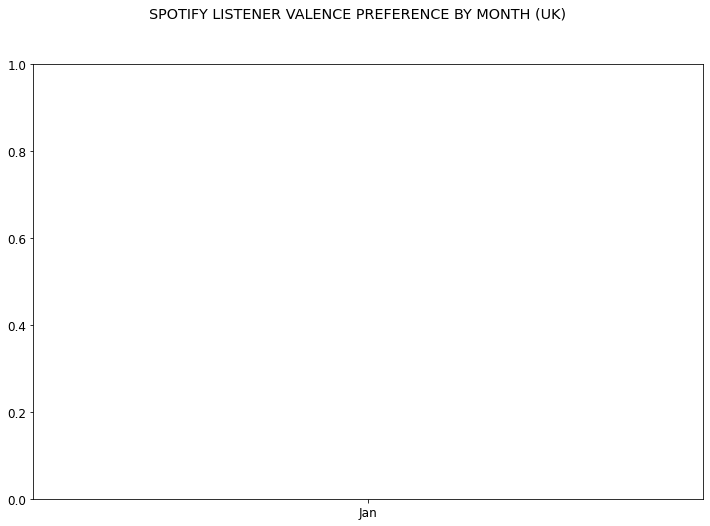

In [37]:
# Plot a comparison of 2019 2020 valence scores

# Set up lists to plot

valence_2019 = country_tracks_data_groupby[country_tracks_data_groupby['Year'] == 2019]

valence_2020 = country_tracks_data_groupby[country_tracks_data_groupby['Year'] == 2020]
valence_2020.drop('Year', inplace=True, axis=1)

fig= plt.figure(figsize=(12,8))                                      # Set up figure size
fig.suptitle('SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH (UK)')         # Set up main title

y_axis = valence_2019['Valence_Stream%']
x_axis = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',                  # Set up x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.plot(x_axis, valence_2019['Valence_Stream%'], label="2019 Weighted Avg Valence", marker='o', color='darkred')  # Plot 2019
plt.plot(x_axis, valence_2020['Valence_Stream%'], label="2020 Weighted Avg Valence", marker='o', color='steelblue')  # Plot 2020

plt.xlabel('Months')                                                 # Set up axis titles
plt.ylabel('Valence Score')

plt.xlim(-0.75, len(x_axis)-0.25)                                    # Set up axis limits
plt.ylim(0, 1)

plt.legend()                                                         # Include the legend

plt.show()


In [38]:
# Compare valence scores with covide infection rate

covid_df = pd.read_csv("input_files/owid-covid-data.csv")                # read the covid data file

country_covid_df = covid_df.loc[covid_df['location'] == 'United Kingdom']   # Filter for country of your choice

country_covid_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
79474,GBR,Europe,United Kingdom,2020-01-31,2.0,2.0,NaN,NaN,NaN,NaN,...,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932
79475,GBR,Europe,United Kingdom,2020-02-01,2.0,0.0,NaN,NaN,NaN,NaN,...,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932
79476,GBR,Europe,United Kingdom,2020-02-02,2.0,0.0,NaN,NaN,NaN,NaN,...,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932
79477,GBR,Europe,United Kingdom,2020-02-03,8.0,6.0,NaN,NaN,NaN,NaN,...,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932
79478,GBR,Europe,United Kingdom,2020-02-04,8.0,0.0,NaN,NaN,NaN,NaN,...,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932


In [39]:
# Filter data for 2020, and add a 'month' column

country_covid__2020_df = country_covid_df[country_covid_df.date.str.contains(r'2020.*')]

country_covid__2020_df['Month'] = ''
country_covid__2020_df.head()

<ipython-input-39-9a7ab2cb5104>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_covid__2020_df['Month'] = ''


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
79474,GBR,Europe,United Kingdom,2020-01-31,2.0,2.0,NaN,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,
79475,GBR,Europe,United Kingdom,2020-02-01,2.0,0.0,NaN,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,
79476,GBR,Europe,United Kingdom,2020-02-02,2.0,0.0,NaN,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,
79477,GBR,Europe,United Kingdom,2020-02-03,8.0,6.0,NaN,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,
79478,GBR,Europe,United Kingdom,2020-02-04,8.0,0.0,NaN,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,


In [40]:
# Extract the month from the 'date' column and add it to the new 'month' column, for sorting later

for index, row in country_covid__2020_df.iterrows():
    month, = re.findall(f"2020-(\d\d)-", row['date'])
    country_covid__2020_df.at[index, 'Month'] = int(month)  

country_covid__2020_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
79474,GBR,Europe,United Kingdom,2020-01-31,2.0,2.0,NaN,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,1
79475,GBR,Europe,United Kingdom,2020-02-01,2.0,0.0,NaN,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,2
79476,GBR,Europe,United Kingdom,2020-02-02,2.0,0.0,NaN,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,2
79477,GBR,Europe,United Kingdom,2020-02-03,8.0,6.0,NaN,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,2
79478,GBR,Europe,United Kingdom,2020-02-04,8.0,0.0,NaN,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,2


In [41]:
# Create a groupby to get the sum of new cases in each month

country_covid__2020_groupby = country_covid__2020_df.groupby(['Month'], as_index=False)['new_cases'].sum()
country_covid__2020_groupby


,Month,new_cases
0,1,2.0
1,2,59.0
2,3,38754.0
3,4,139956.0
4,5,78768.0
5,6,27677.0
6,7,19577.0
7,8,33290.0
8,9,117765.0
9,10,558947.0


In [42]:
# TIP: This next section is to add missing months. In the case of New Zealand, there was no data for January
# For other countries, it might vary. Here's how I added January to the dataframe:

# No need to add january in Italy
# country_covid__2020_groupby.loc[-1] = [1, 0]             # This adds a 1 (month of January) in the first columne 
                                                         # index 0), in the last row of the dataframe. 

# country_covid__2020_groupby.index = country_covid__2020_groupby.index + 1   # shifts the index
country_covid__2020_groupby = country_covid__2020_groupby.sort_index()      # sorts by index

country_covid__2020_groupby = country_covid__2020_groupby.rename(columns={"new_cases": "New Cases"})

country_covid__2020_groupby

,Month,New Cases
0,1,2.0
1,2,59.0
2,3,38754.0
3,4,139956.0
4,5,78768.0
5,6,27677.0
6,7,19577.0
7,8,33290.0
8,9,117765.0
9,10,558947.0


In [43]:
# Merge the dataframes into one nice comparison dataframe to scatter plot

country_covid_valence_df = pd.merge(valence_2020, country_covid__2020_groupby, on="Month")

country_covid_valence_df

,Month,Valence_Stream%,New Cases
0,1,0.508559,2.0
1,2,0.493571,59.0
2,3,0.497763,38754.0
3,4,0.515485,139956.0
4,5,0.494870,78768.0
5,6,0.488749,27677.0
6,7,0.465393,19577.0
7,8,0.491464,33290.0
8,9,0.490684,117765.0
9,10,0.494212,558947.0


In [44]:
# Add a new cases per million column

country_polulation = 67886011  #TIP: This the population of New Zealand. Adjust for your country

country_covid_valence_df['New Cases Per Million'] = country_covid_valence_df['New Cases'] / country_polulation *1000000

country_covid_valence_df

,Month,Valence_Stream%,New Cases,New Cases Per Million
0,1,0.508559,2.0,0.029461
1,2,0.493571,59.0,0.869104
2,3,0.497763,38754.0,570.868717
3,4,0.515485,139956.0,2061.632403
4,5,0.494870,78768.0,1160.297959
5,6,0.488749,27677.0,407.698134
6,7,0.465393,19577.0,288.380474
7,8,0.491464,33290.0,490.380853
8,9,0.490684,117765.0,1734.746206
9,10,0.494212,558947.0,8233.610898


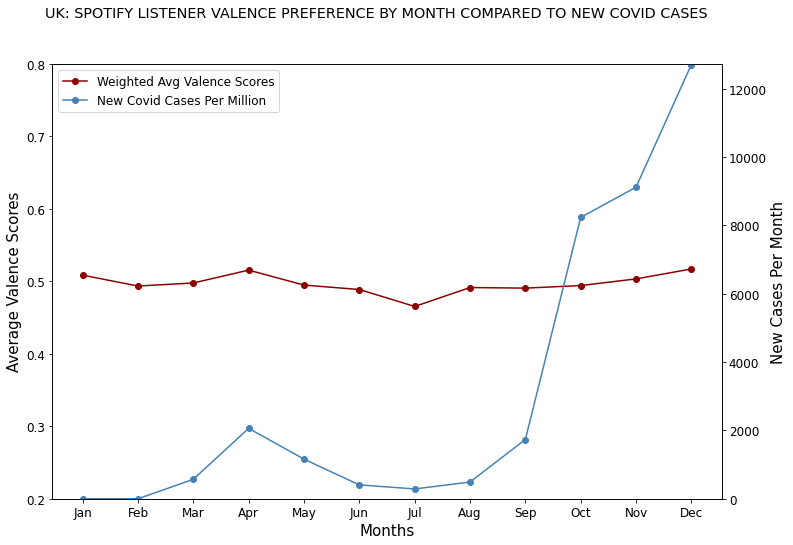

In [30]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

fig, ax1 = plt.subplots(figsize=(12,8))                   # Set up subplot figure and size
fig.suptitle('UK: SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH COMPARED TO NEW COVID CASES')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',       # Set up shared x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ax1.set_xlabel('Months')                

ax1.set_ylabel('Average Valence Scores')                  # Set up first plot 
ax1.set_ylim([.2, .8])

ax1_ydata = country_covid_valence_df['Valence_Stream%']
ax1.plot(months, ax1_ydata, label="Weighted Avg Valence Scores", marker='o', color='darkred')                       
                        
ax2 = ax1.twinx()                                         # Set up second plot 
ax2.set_ylabel('New Cases Per Month')
ax2_ydata = country_covid_valence_df['New Cases Per Million']
ax2.set_ylim([0, ax2_ydata.max()+20])
ax2.plot(months, ax2_ydata, label="New Covid Cases Per Million", marker='o', color='steelblue')


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.show()

In [31]:
# This is a mini function that adds a qualitative label to the correlation r score in the scatter plot

def r_label(r):
    abs_r = abs(r)
    if abs_r >= .8 : return "Very Strong"
    elif abs_r >= .6 : return "Strong"
    elif abs_r >= .4: return "Moderate"
    elif abs_r >= .2: return "Low"
    else: return "Negligible"

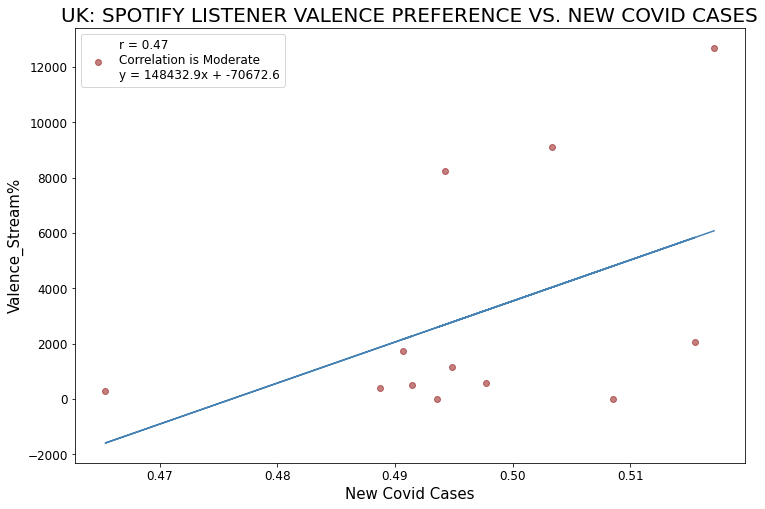

In [32]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

x_axis = country_covid_valence_df['Valence_Stream%']                                 # Set up axes
y_axis = country_covid_valence_df['New Cases Per Million']

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_axis, y_axis)  # Get elements of regression equation
regress_values = x_axis * slope + intercept                                  # Calculate regression values

plt.figure(figsize=(12, 8))
plt.title('UK: SPOTIFY LISTENER VALENCE PREFERENCE VS. NEW COVID CASES') # CHANGE TITLE TO REFLECT YOUR COUNTRY

plt.xlabel(f"New Covid Cases")                                               # Set x axis label for subplot                  
plt.ylabel(f"Valence_Stream%")                                                       # Set title for subplot

r = round(stats.pearsonr(x_axis, y_axis)[0],2)                       # Calculate correlation coefficient
rlabel = r_label(r)                                                 # Call function to create a label for the r number

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))    # Ression formula

plt.scatter(x_axis, y_axis, facecolors="darkred",  alpha=.5,        # Plot the scatter chart
label=f"r = {r}\nCorrelation is {rlabel}\n{line_eq}" ) 

plt.plot(x_axis, regress_values, color="steelblue")                 # Plot the regression line    

plt.legend()                                                        # Add the legend
    
plt.savefig("output_files/valence_vs_newcases.png")                 # Save the png file   

plt.show()